In [1]:
import numpy as np
import copy
import pickle
import os
import matplotlib.pyplot as plt
import random
import networkx as nx
import seaborn as sns
import sympy
import pandas as pd
import math
import networkx.algorithms.community as nxalgo
import scipy
import time
import sys
from itertools import combinations
sys.path.append("E:/学习/研三/Code/Overlapping/compare_CPM/1CliquePercolationMethod-Python-main")
import CliquePercolationMethod as cpm
from igraph import Graph, summary, plot
from functools import partial
from multiprocessing.pool import Pool
from PIL import Image, ImageDraw, ImageFont

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from matplotlib.pyplot import MultipleLocator

sns.set_theme(style="ticks", font='Times New Roman')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.direction'] = 'in'        # 将x轴的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'        # 将y轴的刻度线方向设置向内


color_map = ['#FFFFFF','#FF5733']
color1 = 'darkviolet'
color2 = 'indigo'

#plt.rcParams['font.sans-serif']=['SimHei']
#plt.rcParams['axes.unicode_minus'] = False

In [29]:
## modularity模块度计算
def Q_overlapping2(A, Ze):
    '''
    适用于重叠社团的改进模块度
    网络的模块度为所有社团模块度求和
    Q_ov = 1/2m \sum{c in C}\sum{i,j in V} [cal_F(alpha_i, alpha_j)*A_ij - (beta_lijc_avgi*ki * beta_lijc_avgj*kj)/4m]
    '''
    Q_list_temp = []
    for c in range(K):
        Q_list_temp.append(Q_ov_c(A, Ze, int(c)))
    Q_res = np.sum(Q_list_temp)    # 争议
    return Q_res

In [30]:
k_list = [round(i, 3) for i in np.linspace(20, 70, 11)]
p_list = [round(i, 3) for i in np.array(k_list) / 1000]
overlap_list = [round(i,4) for i in np.linspace(0.10, 0.80, 15)]
size_list = [round(i,4) for i in np.linspace(200, 1000, 17)]

In [31]:
## 将组标签扩展，得到节点数*组数的矩阵，每行代表一个节点，第几个位置为1即分为第几组
## 返回结果：每个节点都是一个数组，属于的组为1，其余为0
def Zform(e, K):
    n = len(e)  #e是节点的分组列表community assgnment，n即为网络大小，共n个节点
    Ze = np.zeros((n, K))  #生成n*K的0矩阵（初始矩阵）
    Ze[np.arange(n), e] = 1  #对每个节点（每行）打标签
    return Ze

## 根据连边概率生成邻接矩阵A
def genA_2communities():
    #Zc = Zform(c, K)  #输入c和组数K，得到扩展的分组矩阵
    Zc = Zform(c, K)
    avg_n = int(n/K)
    avg_overlap = int(overlap_size/K)
    for i in range(avg_n - avg_overlap, avg_n):
        Zc[i][1] = 1
    for i in range(avg_n*K - avg_overlap, avg_n*K):
        Zc[i][0] = 1
    #Omega = np.matmul(np.matmul(Zc, Pstar), np.transpose(Zc))  #Pstar为转移矩阵（p和q未知的情况下，非平衡sbm）
    Omega = np.matmul(Zc, np.transpose(Zc))
    Omega[Omega > 0] = p
    Omega[Omega == 0] = q
    A = np.random.binomial(1, Omega)  #二项分布中采样1个数，Omega为取“正”的概率
    tmp = np.triu(A) - np.diag(np.diag(A))  #A的右上三角阵减去A的特征值
    A = tmp + np.transpose(tmp)
    return A, Zc

## 初始化
seed = 19980210
size = [1000,1000]
#size = [int(size_list[_]),int(2000-size_list[_])]
overlap_ratio = 0.1
p = p_list[3]
# p = 0.03            # 社团内部连接概率
q = 0.01            # 社团之间连接概率
niter = 500
vsteps = 100
trial = 1
beta1 = 1.0
beta2 = 1.0
xi = 1.0
repeat = 1
knowp = True

R = np.diag(size)
K = R.shape[0]
n = np.sum(R)
overlap_size = overlap_ratio * n
c = np.repeat(np.arange(K), np.sum(R, axis=0))

## 连接概率矩阵
Pstar = q * np.ones([K, K]) + np.diag((p - q) * np.ones(K))

A, Zc = genA_2communities()
ZcT = np.transpose(Zc)

In [2]:
## 输入2个社团，统计分组相同的节点数
def nodes_pair_count(X, Y):
    n00 = n01 = n10 = n11 = 0
    for i in range(n):
        if X[i] == 0:
            if Y[i] == 0:
                n00 += 1
            else:
                n01 += 1
        elif X[i] == 1:
            if Y[i] == 0:
                n10 += 1
            else:
                n11 += 1
    return n00, n01, n10, n11

In [3]:
def h_w(w, n):
    '''
    熵的基本运算
    '''
    if w == 0:
        h = 0
    else:
        h = -1 * (w/n) * np.log2(w/n) - (1 - w/n) * np.log2(1 - w/n)
    return h

In [4]:
def H_X(X):
    '''
    独立熵 H(X)
    '''
    w = np.sum(X == 0)
    H_individual = h_w(w, n)
    return H_individual

In [5]:
def H_X_Y(X, Y):
    '''
    联合熵 H(X,Y)
    a = n00
    b = n01
    c = n10
    d = n11
    '''
    n00, n01, n10, n11 = nodes_pair_count(X, Y)
    H_star = h_w(n00, n) + h_w(n11, n)
    return H_star

In [6]:
def H_X_given_Y(X, Y):
    '''
    条件熵 H(X|Y)
    '''
    H_conditional = H_X_Y(X, Y) - H_X(Y)
    return H_conditional

In [7]:
def H_X_given_Y_norm(X, Y):
    '''
    标准条件熵 \bar{H}(X|Y)
    '''
    H_conditional = H_X_Y(X, Y) - H_X(Y)
    H_conditional_norm = H_conditional / H_X(Y)
    return H_conditional_norm

In [ ]:
H_X(ZcT[0])

In [ ]:
H_X(ZcT[1])

In [64]:
H_X_Y(ZcT[0], ZcT[1])

0.4689955935892812

In [61]:
H_X_given_Y(ZcT[0], ZcT[1])

-0.5237788603985271

In [60]:
H_X_given_Y_norm(ZcT[1], ZcT[0])

-0.5275909933969345

In [66]:
H_X_given_Y_norm(ZcT[0], ZcT[0])

1.0

In [8]:
def H_SIAM(ZcT, ZeT):
    '''
    输入 实际划分情况（所有社团），算法划分情况（单个社团）
    遍历实际划分的所有社团，输出划分情况与实际情况匹配最佳情形
    '''
    rank_list_temp = []
    for X in ZcT:
        for Y in ZeT:
            n00, n01, n10, n11 = nodes_pair_count(X, Y)
            
    return X_rank_correlation

In [24]:
def Spearman_rank_correlation(ZcT, X):
    '''
    输入 实际划分情况（所有社团），算法划分情况（单个社团）
    输出划分情况与实际情况匹配最佳情形
    '''
    rank_list_temp = []
    for Y in ZcT:
        rank_diff = np.sum(np.square(X - Y))
        rank = 1 - rank_diff / len(X)
        rank_list_temp.append(rank)
    X_rank_correlation = np.max(rank_list_temp)
    return X_rank_correlation

In [25]:
def adjusted_Spearman_rank_correlation(ZcT, X):
    '''
    输入 实际划分情况（所有社团），算法划分情况（单个社团）
    遍历实际划分的所有社团，输出划分情况与实际情况匹配最佳情形
    '''
    rank_list_temp = []
    for Y in ZcT:
        community_diff = Y - X
        a = np.sum((community_diff == 0) * (Y == 1))   # 实际在该社团，判断在该社团      Y = 1, X = 1
        b = np.sum(community_diff == 1)                # 实际在该社团，判断不在该社团    Y = 1, X = 0
        c = np.sum(community_diff == -1)               # 实际不在该社团，判断在该社团    Y = 0, X = 1
        
        rank = a / np.sqrt((a+b) * (a+c))
        rank_list_temp.append(rank)
    X_rank_correlation = np.max(rank_list_temp)
    return X_rank_correlation

In [26]:
def RC_avg(ZcT, ZeT):
    '''
    输入 实际划分情况（所有社团），算法划分情况（所有社团）
    遍历算法结果的所有社团，输出算法结果中所有社团的RC均值
    '''
    K_max = np.max([len(ZcT), len(ZeT)])
    RC_list = []
    for X in ZeT:
        RC_list.append(Spearman_rank_correlation(ZcT, X))
    RC = np.sum(RC_list) / K_max
    return RC

In [27]:
def FMI_avg(ZcT, ZeT):
    '''
    输入 实际划分情况（所有社团），算法划分情况（所有社团）
    遍历算法结果的所有社团，输出算法结果中所有社团的ARC均值
    '''
    K_max = np.max([len(ZcT), len(ZeT)])
    FMI_list = []
    for X in ZeT:
        FMI_list.append(adjusted_Spearman_rank_correlation(ZcT, X))
    FMI = np.sum(FMI_list) / K_max
    return FMI

In [28]:
def gamma2Ze(gamma):
    gamma_norm = gamma / np.sum(gamma, axis=1)[0]
    threshold = 1 / len(gamma_norm[0]) *0.9
    Ze_MMSBM = gamma_norm > threshold
    Ze_MMSBM = Ze_MMSBM + 0
    return Ze_MMSBM

Karate Figure

In [33]:
def logpost_cal(Ze0):
    curr_Ze = copy.deepcopy(Ze0)  #深复制一个打乱后的标签
    Econnect_Ze = np.matmul(curr_Ze, np.transpose(curr_Ze)).astype(float)
    Econnect_Ze[Econnect_Ze > 0] = p
    Econnect_Ze[Econnect_Ze == 0] = q

    E_A = (Econnect_Ze * A) + ((1-Econnect_Ze) * (1 - A))
    #E_A = E_A - np.diag(np.diag(E_A))
    logpostA = np.log(E_A)
    logpostA = logpostA - np.diag(np.diag(logpostA))
    return np.sum(logpostA) / 2

In [6]:
G = nx.karate_club_graph()
A = np.array(nx.adjacency_matrix(G).todense())
A[A>=1] = 1

<ipython-input-6-f7b573da906e>:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense())


In [32]:
n = len(A)
p = np.sum(A) / n / n
q = 0.0001

In [52]:
community_num_candidate = np.array([[1,0],
                                   [0,1],
                                   [1,1]])

In [12]:
dirkarate = "E:/学习/研三/Code/Overlapping/karate/"

In [87]:
data_temp = pickle.load(open(dirkarate + "GSBM_karateK2" + ".pkl", 'rb'))
Ze_karate_SFMC = data_temp[1][0]

In [88]:
karate_community_SFMC = []
for i in range(len(Ze_karate_SFMC)):
    community_vec = Ze_karate_SFMC[i]
    for j in range(len(community_num_candidate)):
        group = community_num_candidate[j]
        judge = sum(community_vec == community_num_candidate[j])
        if judge == 2:
            karate_community_SFMC.append(j)

<ipython-input-88-a196dcf004a1>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  judge = sum(community_vec == community_num_candidate[j])


TypeError: 'bool' object is not iterable

In [89]:
karate_community_SFMC

[]

In [70]:
pd.DataFrame(karate_community_SFMC).to_csv(dirkarate + "Ze_karate_SFMC" + ".csv", index=False)
pd.DataFrame(A).to_csv(dirkarate + "A_karate" + ".csv", index=False)

In [77]:
data_temp = pickle.load(open(dirkarate + "GSBM_karateK3" + ".pkl", 'rb'))
Ze_karate_SFMC = data_temp[1][0]

In [78]:
community_num_candidate = np.array([[1,0,0],
                                   [1,1,0],
                                   [0,1,0],
                                   [0,1,1],
                                   [0,0,1],
                                   [1,0,1],
                                   [1,1,1]])

In [79]:
karate_community_SFMC = []
for i in range(len(Ze_karate_SFMC)):
    community_vec = Ze_karate_SFMC[i]
    for j in range(len(community_num_candidate)):
        group = community_num_candidate[j]
        judge = sum(community_vec == community_num_candidate[j])
        if judge == 3:
            karate_community_SFMC.append(j)

In [80]:
karate_community_SFMC

[6,
 1,
 6,
 0,
 5,
 4,
 3,
 0,
 5,
 4,
 3,
 4,
 0,
 1,
 5,
 4,
 3,
 2,
 2,
 2,
 3,
 3,
 5,
 5,
 5,
 1,
 4,
 0,
 4,
 3,
 5,
 3,
 3,
 6]

In [81]:
pd.DataFrame(karate_community_SFMC).to_csv(dirkarate + "Ze_karate_SFMCK3" + ".csv", index=False)
pd.DataFrame(A).to_csv(dirkarate + "A_karate" + ".csv", index=False)

In [82]:
graph = nx.from_numpy_matrix(A)

In [41]:
for K in range(2, 6):
    data_temp = pickle.load(open(dirkarate + "MMSBM_karateK" + str(K) + ".pkl", 'rb'))
    Ze_karate_MMSBM = data_temp[2]
    print(logpost_cal(Ze_karate_MMSBM))

-226.241940305497
-479.19209274901596
-384.9154503981024
-338.66423028039424


In [43]:
data_temp = pickle.load(open(dirkarate + "MMSBM_karateK" + str(2) + ".pkl", 'rb'))
Ze_karate_MMSBM = data_temp[2]

In [ ]:
karate_community_MMSBM = []
for i in range(len(Ze_karate_MMSBM)):
    community_vec = Ze_karate_MMSBM[i]
    for j in range(len(community_num_candidate)):
        group = community_num_candidate[j]
        judge = sum(community_vec == community_num_candidate[j])
        if judge == 3:
            karate_community_MMSBM.append(j)

In [21]:
data_temp = pickle.load(open(dirkarate + "GA_karateK3" + ".pkl", 'rb'))

In [27]:
Ze_karate_GA = data_temp[0].astype(int)

In [28]:
karate_community_GA = []
for i in range(len(Ze_karate_GA)):
    community_vec = Ze_karate_GA[i]
    for j in range(len(community_num_candidate)):
        group = community_num_candidate[j]
        judge = sum(community_vec == community_num_candidate[j])
        if judge == 3:
            karate_community_GA.append(j)

In [29]:
karate_community_GA

[4,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 2,
 5,
 4,
 4,
 4,
 5,
 2,
 1,
 5,
 4,
 2,
 6,
 1,
 5,
 2,
 1,
 1,
 0,
 2,
 2,
 4,
 1,
 1,
 1,
 2,
 2]

MMSBM Aritificial network

In [16]:
k_list = [round(i, 3) for i in np.linspace(10, 70, 13)]
p_list = [round(i, 3) for i in np.array(k_list) / 1000]
overlap_list = [round(i,4) for i in np.linspace(0.10, 0.80, 15)]
size_list = [round(i,4) for i in np.linspace(200, 1000, 17)]

In [17]:
p, q, overlap_size

(0.065, 0.01, 200.0)

In [37]:
p_list1 = [round(i, 3) for i in np.linspace(0.01, 0.07, 7)]
overlap_list1 = [round(i,4) for i in np.linspace(0.10, 0.80, 8)]

In [39]:
p = 0.03

In [44]:
for i in size_list:
    overlap_size = 200.0
    dir_MMSBM = "E:/学习/研三/Code/Overlapping/compare_MMSBM" + "/unbalance" + "/K" + str(K) + "n" + str(2000) + "size" + str(int(i)) + "op" + str(overlap_size) + "p" + str(p) + "q" + str(q) + "/"
    data_temp = pickle.load(open(dir_MMSBM + '' + '.pkl','rb'))
    Ze = gamma2Ze(data_temp[0])
    ZeT = np.transpose(Ze)
    ZeT = np.transpose(Ze)
    ZeT_clean = []
    for i in ZeT:
        if sum(i) != 0:
            ZeT_clean.append(i)
    FMI = FMI_avg(ZcT, ZeT_clean)
    print(FMI)

0.3708099243547831
0.7416198487095662
0.6301928465008324
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831
0.3708099243547831


FileNotFoundError: [Errno 2] No such file or directory: 'E:/学习/研三/Code/Overlapping/compare_MMSBM/unbalance/K2n2000size1000op200.0p0.03q0.01/.pkl'

In [46]:
500000*0.8*0.01

4000.0

In [47]:
100000*0.6*0.01

600.0

# Facebook_Table

In [16]:
dir_data = "E:/学习/研三/Code/Rplot/overlapping/"
method_name = ["", "SFMC_", "GA_", "LPA_"]
method_select = method_name[0]

dir_vertices = dir_data + "facebook_" + method_select + "vertices" + ".csv"
dir_hierarchy = dir_data + "facebook_" + method_select + "hierarchy" + ".csv"
dir_connections = dir_data + "facebook_" + method_select + "connections" + ".csv"

df_vertices = pd.read_csv(dir_vertices)
df_connections = pd.read_csv(dir_connections)

In [17]:
df_vertices

,name,degree,community
0,157,220,1
1,467,213,1
2,135,211,1
3,71,204,1
4,120,203,1
...,...,...,...
504,group1,227,10
505,group2,5,10
506,group3,112,10
507,group4,16,10


In [67]:
array_vertices = np.array(df_vertices)
array_vertices

array([['157', 220, 1],
       ['467', 213, 1],
       ['135', 211, 1],
       ...,
       ['group3', 112, 10],
       ['group4', 16, 10],
       ['group5', 143, 10]], dtype=object)

In [18]:
df_connections

,from,to
0,157,6
1,157,7
2,157,8
3,157,9
4,157,10
...,...,...
23562,281,42
23563,281,119
23564,359,473
23565,473,359


In [68]:
array_connections = np.array(df_connections)
array_connections

array([[157,   6],
       [157,   7],
       [157,   8],
       ...,
       [359, 473],
       [473, 359],
       [ 42,  91]], dtype=int64)

In [22]:
x_temp = np.array(df_connections)[0][0]
y_temp = np.array(df_connections)[0][1]

In [31]:
x_temp

157

In [37]:
df_x = df_vertices[df_vertices['name']==str(x_temp)]
df_y = df_vertices[df_vertices['name']==str(y_temp)]

In [52]:
df_x.iloc[0][2]

1

In [49]:
df_y.iloc[0][2]

1

In [64]:
df_vertices[df_vertices['name']==str(91)].iloc[0][2]

5

In [61]:
np.array(df_connections)[-1]

array([42, 91], dtype=int64)

In [65]:
community_connection = []
for i in np.array(df_connections):
    x = i[0]
    y = i[1]
    df_x = df_vertices[df_vertices['name']==str(x)]
    df_y = df_vertices[df_vertices['name']==str(y)]
    
    x_community = df_x.iloc[0][2]
    y_community = df_y.iloc[0][2]
    community_connection.append([x_community, y_community])

In [72]:
df_community_connections = pd.DataFrame(community_connection)
df_community_connections.columns = ['community_from', 'community_to']
#to_csv('E:/学习/研三/Code/Rplot/overlapping/artificial_hierarchy.csv', index=False)
df_community_connections

,community_from,community_to
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
23562,5,5
23563,5,5
23564,5,5
23565,5,5


In [28]:
Ze_coef_dolphins = pickle.load(open("E:/学习/研三/Code/Overlapping/recurrent" + '/dolphins_GAK4iter400' + '.pkl','rb'))

In [33]:
Ze_coef_dolphins_norm = copy.deepcopy(Ze_coef_dolphins)

In [35]:
Ze_coef_dolphins_norm[0] / np.sum(Ze_coef_dolphins_norm[0])

array([0.07629428, 0.36076294, 0.03378747, 0.52915531])

In [31]:
Ze_dolphins = copy.deepcopy(Ze_coef_dolphins)
Ze_dolphins[Ze_dolphins >= 0.25] = 1
Ze_dolphins[Ze_dolphins < 0.25] = 0
Ze_dolphins

array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 0., 0., 1.],
       [1., 1., 1., 0.],
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 0., 1., 1.],
       [0., 1., 1., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],


In [41]:
Ze_LPA_SIAM = pickle.load(open("E:/学习/研三/Code/Overlapping/recurrent" + '/SIAM_LPAd40v6rho0.05iter10' + '.pkl','rb'))

In [45]:
len(Ze_LPA_SIAM[0][0])

104

# Figure Plot

In [2]:
dir_facebook = "E:/学习/研三/Code/Overlapping/facebook"
dir_twitter = "E:/学习/研三/Code/Overlapping/twitter"
dir_DBLP = "E:/学习/研三/Code/Overlapping/3DBLP"

In [3]:
select_name_facebook = np.array(['1912','1684', '348'])
select_name_twitter =  np.array(['229741646', '230601773', '30207757', '16809036', '73025843', '17396702', '19898730', '63207451'])
select_name_DBLP = np.array(['DBLP2', 'DBLP3'])

In [21]:
facebook_Zc = pickle.load(open(dir_facebook + '/facebook_Zc_list' + '.pkl','rb'))
twitter_Zc = pickle.load(open(dir_twitter + '/twitter_Zc_list' + '.pkl','rb'))

In [22]:
Zc_1912, Zc_1684, Zc_348 = facebook_Zc

In [23]:
len(Zc_1912), len(Zc_1684), len(Zc_348)

(503, 376, 207)

In [24]:
ZcT_1912, ZcT_1684, ZcT_348 = np.transpose(Zc_1912), np.transpose(Zc_1684), np.transpose(Zc_348)

In [36]:
ZcT_1912

array([[1, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1]])

In [40]:
np.sum(ZeT_MMSBM_1912, axis=1)

array([213,   0, 503])

In [49]:
dir_facebook_res = dir_facebook + "/" + "MMSBM" + "_" + "facebook"
dir_res = dir_facebook_res + "1912"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))
Ze_MMSBM_1912 = gamma2Ze(data_temp[0])
ZeT_MMSBM_1912 = np.transpose(Ze_MMSBM_1912)
FMI = FMI_avg(ZcT_1912, [ZeT_MMSBM_1912[0],ZeT_MMSBM_1912[2]])
FMI

0.4908301559853596

In [54]:
dir_facebook_res = dir_facebook + "/" + "MMSBM" + "_" + "facebook"
dir_res = dir_facebook_res + "1684"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))
Ze_MMSBM_1684 = gamma2Ze(data_temp[0])
ZeT_MMSBM_1684 = np.transpose(Ze_MMSBM_1684)
FMI = FMI_avg(ZcT_1684, ZeT_MMSBM_1684[1])
FMI / 2

0.38506009478488507

In [51]:
dir_facebook_res = dir_facebook + "/" + "MMSBM" + "_" + "facebook"
dir_res = dir_facebook_res + "348"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))
Ze_MMSBM_348 = gamma2Ze(data_temp[0])
ZeT_MMSBM_348 = np.transpose(Ze_MMSBM_348)
FMI = FMI_avg(ZcT_348, ZeT_MMSBM_348)
FMI

0.8393589076973171

In [20]:
method_name = np.array(['SFMC', 'GA', 'LPA', 'CPM'])

In [18]:
method_select = 'SFMC'
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook"
for i in select_name_facebook:
    dir_res = dir_facebook_res + "1912"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [28]:
FMI_SFMC_facebook1912 = []
for i in range(len(data_temp[4])):
    ZeT_temp = np.transpose(data_temp[4][i])
    FMI_SFMC_facebook1912.append(FMI_avg(ZcT_1912, ZeT_temp))
    
FMI_SFMC_facebook1912

[0.8922116462212154,
 0.7146273891641662,
 0.5821997584029361,
 0.6850658195822156,
 0.6596565495365235,
 0.752353644551238,
 0.7279403927628881,
 0.8922877933983052,
 0.9244146360688661,
 0.9184217889530881]

In [234]:
with open(dir_facebook + "/" + "FMI_SFMC_facebook1912" + ".pkl", "wb") as out:
    pickle.dump(FMI_SFMC_facebook1912, out)

In [29]:
method_select = 'SFMC'
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook"
for i in select_name_facebook:
    dir_res = dir_facebook_res + "1684"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [30]:
ZcT_1684 = np.transpose(Zc_1684)
FMI_SFMC_facebook1684 = []
for i in range(len(data_temp[4])):
    ZeT_temp = np.transpose(data_temp[4][i])
    FMI_SFMC_facebook1684.append(FMI_avg(ZcT_1684, ZeT_temp))

FMI_SFMC_facebook1684

[0.9886503903452313,
 0.9743854311054794,
 0.9913422760770922,
 0.9234343543861382,
 0.9913422760770922,
 0.9886503903452313,
 0.9913422760770922,
 0.9859707218511746,
 0.6675132585807585,
 0.9913422760770922]

In [233]:
with open(dir_facebook + "/" + "FMI_SFMC_facebook1684" + ".pkl", "wb") as out:
    pickle.dump(FMI_SFMC_facebook1684, out)

In [31]:
method_select = 'SFMC'
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook"
for i in select_name_facebook:
    dir_res = dir_facebook_res + "348"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [32]:
ZcT_348 = np.transpose(Zc_348)
FMI_SFMC_facebook348 = []
for i in range(len(data_temp[4])):
    ZeT_temp = np.transpose(data_temp[4][i])
    FMI_SFMC_facebook348.append(FMI_avg(ZcT_348, ZeT_temp))

FMI_SFMC_facebook348

[0.8546080016990678,
 0.8378538067987259,
 0.8167905863422948,
 0.8622742118995804,
 0.8197518866176026,
 0.8160084087962954,
 0.8115798238876177,
 0.8192590673181073,
 0.8295792005344718,
 0.8153613359947001]

In [232]:
with open(dir_facebook + "/" + "FMI_SFMC_facebook348" + ".pkl", "wb") as out:
    pickle.dump(FMI_SFMC_facebook348, out)

In [11]:
FMI_facebook_list_SFMC = [0.9244146360688661, 0.9913422760770922, 0.8622742118995804]

Facebook_GA

In [108]:
dir_GA_facebook = "E:/学习/研三/Code/Overlapping/compare_GA2/"
dir_res = dir_GA_facebook + "GA_" + "facebook" + "1912"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [118]:
Ze_GA_1912 = data_temp[0]
Ze_GA_1912

array([[1., 0., 1.],
       [1., 1., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 0., 1.]])

In [120]:
ZeT_GA_1912 = np.transpose(Ze_GA_1912)

FMI_GA_facebook1912 = FMI_avg(ZcT_1912, ZeT_GA_1912)
FMI_GA_facebook1912

0.46692376516907325

In [121]:
dir_GA_facebook = "E:/学习/研三/Code/Overlapping/compare_GA2/"
dir_res = dir_GA_facebook + "GA_" + "facebook" + "1684"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [122]:
Ze_GA_1684 = data_temp[0]
Ze_GA_1684

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [123]:
ZeT_GA_1684 = np.transpose(Ze_GA_1684)

FMI_GA_facebook1684 = FMI_avg(ZcT_1684, ZeT_GA_1684)
FMI_GA_facebook1684

0.47856270387731115

In [125]:
dir_GA_facebook = "E:/学习/研三/Code/Overlapping/compare_GA2/"
dir_res = dir_GA_facebook + "GA_" + "facebook" + "348"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [126]:
Ze_GA_348 = data_temp[0]
Ze_GA_348

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [127]:
ZeT_GA_348 = np.transpose(Ze_GA_348)

FMI_GA_facebook348 = FMI_avg(ZcT_348, ZeT_GA_348)
FMI_GA_facebook348

0.5934315800604552

In [11]:
FMI_facebook_list_SFMC = [0.9244146360688661, 0.9913422760770922, 0.8622742118995804]

In [12]:
FMI_facebook_list_GA = [0.46692376516907325, 0.47856270387731115, 0.5934315800604552]

Facebook_LPA

In [171]:
method_select = 'LPA'
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook"
for i in select_name_facebook:
    dir_res = dir_facebook_res + "1912" + "v3" + "repeat5"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [172]:
len(data_temp[0][0])

503

In [173]:
Ze_LPA_temp = data_temp[0][0]
ZeT_LPA_temp = np.transpose(Ze_LPA_temp)

In [174]:
FMI_avg(ZcT_1912, np.transpose(data_temp[0][0]))

0.6118005682616353

In [160]:
method_select = 'LPA'
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook"
for i in select_name_facebook:
    dir_res = dir_facebook_res + "1684" + "v3" + "repeat5"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [162]:
len(data_temp[0][0])

376

In [163]:
Ze_LPA_temp = data_temp[0][0]
ZeT_LPA_temp = np.transpose(Ze_LPA_temp)

In [164]:
FMI_avg(ZcT_1684, np.transpose(data_temp[0][0]))

0.9945165176554838

In [165]:
method_select = 'LPA'
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook"
for i in select_name_facebook:
    dir_res = dir_facebook_res + "348" + "v3" + "repeat5"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [167]:
len(data_temp[0][0])

207

In [168]:
Ze_LPA_temp = data_temp[0][0]
ZeT_LPA_temp = np.transpose(Ze_LPA_temp)

In [170]:
FMI_avg(ZcT_348, np.transpose(data_temp[0][0]))

0.40006772905760624

In [13]:
FMI_facebook_list_LPA = [0.6118005682616353, 0.9945165176554838,  0.40006772905760624]

In [11]:
FMI_facebook_list_SFMC = [0.9244146360688661, 0.9913422760770922, 0.8622742118995804]

In [12]:
FMI_facebook_list_GA = [0.46692376516907325, 0.47856270387731115, 0.5934315800604552]

Facebook_CPM

In [25]:
ZeT_CPM = np.zeros([len(community_list), n])
for i in range(len(community_list)):
    community_temp = community_list[i]
    for j in community_temp:
        ZeT_CPM[i][j] = 1

Ze_CPM = np.transpose(ZeT_CPM)

In [30]:
FMI = FMI_avg(ZcT_1912, ZeT_CPM)
FMI

0.42908281572559365

In [28]:
len(Ze_CPM[0])

6

In [14]:
FMI_facebook_list_CPM = [0.42908281572559365, 0.6385777695420125,  0.6129098366191739]

In [13]:
FMI_facebook_list_LPA = [0.6118005682616353, 0.9945165176554838,  0.40006772905760624]

In [55]:
FMI_facebook_list_NILPA = [0.3391313758015007, 0.9945165176554838, 0.3196842980117411]

In [11]:
FMI_facebook_list_SFMC = [0.9244146360688661, 0.9913422760770922, 0.8622742118995804]

In [12]:
FMI_facebook_list_GA = [0.46692376516907325, 0.47856270387731115, 0.5934315800604552]

In [56]:
FMI_facebook_list_MMSBM = [0.4908301559853596, 0.38506009478488507, 0.8393589076973171]

Twitter_SFMC

In [57]:
select_name_twitter0 = np.array(['229741646', '230601773', '30207757', '16809036', '129984134',
       '73025843', '17396702', '19898730', '63207451'])
select_name_twitter = np.delete(select_name_twitter0, [4])

In [23]:
select_name_twitter

array(['229741646', '230601773', '30207757', '16809036', '73025843',
       '17396702', '19898730', '63207451'], dtype='<U9')

In [58]:
Zc_list_twitter0 = pickle.load(open(dir_twitter + '/twitter_Zc_list' + '.pkl','rb'))
Zc_list_twitter = np.delete(Zc_list_twitter0, [4])
len(Zc_list_twitter)

D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


8

In [59]:
[len(Zc_list_twitter0[i]) for i in range(9)]

[94, 95, 63, 157, 127, 60, 81, 192, 114]

In [60]:
[len(Zc_list_twitter[i]) for i in range(8)]

[94, 95, 63, 157, 60, 81, 192, 114]

In [62]:
method_select = 'MMSBM'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

In [63]:
dir_res = dir_twitter_res + select_name_twitter[0]
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [77]:
for _ in range(8):
    dir_res = dir_twitter_res + select_name_twitter[_]
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

    Ze_temp = gamma2Ze(data_temp[0])
    ZeT_temp = np.transpose(Ze_temp)
    ZeT_clean = []
    for i in ZeT_temp:
        if sum(i) != 0:
            ZeT_clean.append(i)
    FMI = FMI_avg(np.transpose(Zc_list_twitter[_]), ZeT_clean)
    print(FMI)

0.7151122423350186
0.5655696330019326
0.8397946934743041
0.6418553746027678
0.6513340255853058
0.6510158928372065
0.414578098794425
0.8243044047979038


In [134]:
method_select = 'SFMC'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

In [146]:
FMI_twitter_list_SFMC = []
for i in range(len(select_name_twitter)):
    twitter_name = select_name_twitter[i]
    dir_res = dir_twitter_res + twitter_name
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    
    Ze_SFMC_list_twitter = data_temp[4]
    FMI_twitter_list_temp = []
    for _ in Ze_SFMC_list_twitter:
        FMI_twitter_list_temp.append(FMI_avg(np.transpose(Zc_list_twitter[i]), np.transpose(_)))
    FMI_twitter_list_SFMC.append(np.max(FMI_twitter_list_temp))

In [147]:
FMI_twitter_list_SFMC

[0.48280664097295706,
 0.4848382814375344,
 0.7552713284625946,
 0.6942827023749921,
 0.5941143383092037,
 0.7733782563289266,
 0.7704509363988221,
 0.7942396205646369]

In [18]:
FMI_twitter_list_SFMC = [0.48280664097295706,
 0.4848382814375344,
 0.7552713284625946,
 0.6942827023749921,
 0.5941143383092037,
 0.7733782563289266,
 0.7704509363988221,
 0.7942396205646369]

Twitter_GA

In [45]:
method_select = 'GA'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

twitter_name = select_name_twitter[0]
dir_res = dir_twitter_res + twitter_name
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [46]:
data_temp

[array([[0., 0., 1., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 1.],
        ...,
        [0., 1., 1., ..., 0., 0., 1.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 array([[0.05 , 0.05 , 0.06 , ..., 0.01 , 0.02 , 0.06 ],
        [0.62 , 0.036, 0.01 , ..., 0.04 , 0.02 , 0.05 ],
        [0.57 , 0.06 , 0.014, ..., 0.02 , 0.01 , 0.06 ],
        ...,
        [0.04 , 0.648, 0.08 , ..., 0.008, 0.01 , 0.09 ],
        [0.48 , 0.108, 0.02 , ..., 0.01 , 0.03 , 0.05 ],
        [0.14 , 0.22 , 0.06 , ..., 0.02 , 0.02 , 0.05 ]]),
 nan]

In [48]:
ZcT_temp = np.transpose(Zc_list_twitter[0])
ZeT_GA_temp = np.transpose(data_temp[0])
FMI_avg(ZcT_temp, ZeT_GA_temp)

<ipython-input-10-a2be9795f351>:13: RuntimeWarning: invalid value encountered in true_divide
  rank = a / np.sqrt((a+b) * (a+c))


nan

In [54]:
method_select = 'GA'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

twitter_name = select_name_twitter[1]
dir_res = dir_twitter_res + twitter_name
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [55]:
ZcT_temp = np.transpose(Zc_list_twitter[1])
ZeT_GA_temp = np.transpose(data_temp[0])
FMI_avg(ZcT_temp, ZeT_GA_temp)

<ipython-input-10-a2be9795f351>:13: RuntimeWarning: invalid value encountered in true_divide
  rank = a / np.sqrt((a+b) * (a+c))


nan

In [56]:
method_select = 'GA'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

twitter_name = select_name_twitter[2]
dir_res = dir_twitter_res + twitter_name
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [57]:
ZcT_temp = np.transpose(Zc_list_twitter[2])
ZeT_GA_temp = np.transpose(data_temp[0])
FMI_avg(ZcT_temp, ZeT_GA_temp)

0.5714235608571163

In [19]:
FMI_twitter_list_GA = [0,
0,
0.5714235608571163,
0.5627312815251572,
0.6200875401731015,
0.5834572112183929,
0.5109886516784548,
0.5868505326399869]

In [18]:
FMI_twitter_list_SFMC = [0.48280664097295706,
 0.4848382814375344,
 0.7552713284625946,
 0.6942827023749921,
 0.5941143383092037,
 0.7733782563289266,
 0.7704509363988221,
 0.7942396205646369]

Twitter_LPA

In [117]:
method_select = 'LPA'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

twitter_name = select_name_twitter[0]
dir_res = dir_twitter_res + twitter_name + "v7" + "repeat5"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [124]:
for i in range(8):
    twitter_name = select_name_twitter[i]
    dir_res = dir_twitter_res + twitter_name + "v7" + "repeat5"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

    Ze_LPA_temp = data_temp[0][0]
    ZeT_LPA_temp = np.transpose(Ze_LPA_temp)
    Zc_temp = data_temp[1]
    ZcT_temp = np.transpose(Zc_temp)

    FMI = FMI_avg(ZcT_temp, ZeT_LPA_temp)
    print(FMI)

0.05555555555555555
0.05
0.5
0.3444543196275017
0.1652719420071502
0.4648111258522642
0.414578098794425
0.5


In [20]:
FMI_twitter_list_LPA = [0.05555555555555555,
0.05,
0.5,
0.3444543196275017,
0.1652719420071502,
0.4648111258522642,
0.414578098794425,
0.5]

In [19]:
FMI_twitter_list_GA = [0,
0,
0.5714235608571163,
0.5627312815251572,
0.6200875401731015,
0.5834572112183929,
0.5109886516784548,
0.5868505326399869]

In [18]:
FMI_twitter_list_SFMC = [0.48280664097295706,
 0.4848382814375344,
 0.7552713284625946,
 0.6942827023749921,
 0.5941143383092037,
 0.7733782563289266,
 0.7704509363988221,
 0.7942396205646369]

Twitter_CPM

In [119]:
method_select = 'CPM'
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter"

dir_res = dir_twitter_res + select_name_twitter[0]
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [120]:
data_temp

[[1, 1],
 [90, 89],
 array([[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 1, 0],
        [1, 1, 0, ..., 1, 0, 1],
        [0, 1, 0, ..., 0, 1, 0]]),
 [[[0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    32,
    33,
    34,
    35,
    36,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    89,
    90,
    91,
    92,
    93]],
  [[0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,

In [79]:
FMI_twitter_list_CPM = [0.05436067275445352,
                       0.049470884579241474,
                       0.5,
                       0.5904583108457263,
                       0.22366925844074126,
                       0.44872353833158096,
                       0.45193237603883096,
                       0.44917077594709154]

In [80]:
FMI_twitter_list_MMSBM = [0.7151122423350186,
                        0.5655696330019326,
                        0.8397946934743041,
                        0.6418553746027678,
                        0.6513340255853058,
                        0.6510158928372065,
                        0.414578098794425,
                        0.8243044047979038]

In [81]:
FMI_twitter_list_LPA = [0.05555555555555555,
0.05,
0.5,
0.3444543196275017,
0.1652719420071502,
0.4648111258522642,
0.414578098794425,
0.5]

In [82]:
FMI_twitter_list_NILPA = [0.05555555555555555,
0.05,
0.5,
0.28309270690836397,
0.23039894614796777,
0.4648111258522642,
0.2379529950244269,
0.5]

In [83]:
FMI_twitter_list_GA = [0,
0,
0.5714235608571163,
0.5627312815251572,
0.6200875401731015,
0.5834572112183929,
0.5109886516784548,
0.5868505326399869]

In [84]:
FMI_twitter_list_SFMC = [0.48280664097295706,
 0.4848382814375344,
 0.7552713284625946,
 0.6942827023749921,
 0.5941143383092037,
 0.7733782563289266,
 0.7704509363988221,
 0.7942396205646369]

DBLP_SFMC

In [4]:
Zc_DBLP2 = pickle.load(open(dir_DBLP + "/" + "Zc_DBLP2" + '.pkl','rb'))
Zc_DBLP3 = pickle.load(open(dir_DBLP + "/" + "Zc_DBLP3" + '.pkl','rb'))

In [5]:
ZcT_DBLP2 = np.transpose(Zc_DBLP2)
ZcT_DBLP3 = np.transpose(Zc_DBLP3)

In [100]:
method_select = 'SFMC'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"
for i in select_name_facebook:
    dir_res = dir_DBLP_res + "2"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [105]:
FMI_SFMC_dblp2 = []
for i in range(len(data_temp[4])):
    ZeT_temp = np.transpose(data_temp[4][i])
    FMI_SFMC_dblp2.append(FMI_avg(ZcT_DBLP2, ZeT_temp))
    
FMI_SFMC_dblp2

[0.542010503770863, 0.5426739971615054, 0.5429797469309784]

In [107]:
method_select = 'SFMC'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"
for i in select_name_facebook:
    dir_res = dir_DBLP_res + "3"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [108]:
FMI_SFMC_dblp3 = []
for i in range(len(data_temp[4])):
    ZeT_temp = np.transpose(data_temp[4][i])
    FMI_SFMC_dblp3.append(FMI_avg(ZcT_DBLP3, ZeT_temp))
    
FMI_SFMC_dblp3

[0.4917793273541404, 0.4775594031576813, 0.4775779017467547]

DBLP_GA

In [175]:
method_select = 'GA'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"
for i in select_name_facebook:
    dir_res = dir_DBLP_res + "2"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [177]:
Ze_GA_coef = data_temp[1]
Ze_GA_coef

array([[0.39, 0.04, 0.53],
       [0.16, 0.24, 0.53],
       [0.01, 0.29, 0.36],
       ...,
       [0.32, 0.19, 0.81],
       [0.3 , 0.26, 0.57],
       [0.39, 0.15, 0.44]])

In [183]:
Ze_GA_coef[Ze_GA_coef > round(1/3, 4)] = 1
Ze_GA_coef[Ze_GA_coef <= round(1/3, 4)] = 0

Ze_GA_DBLP2 = copy.deepcopy(Ze_GA_coef)
ZeT_GA_DBLP2 = np.transpose(Ze_GA_DBLP2)

In [189]:
FMI_GA_dblp2 = FMI_avg(ZcT_DBLP2, ZeT_GA_DBLP2)
FMI_GA_dblp2

0.5717041034854825

In [190]:
method_select = 'GA'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"
for i in select_name_facebook:
    dir_res = dir_DBLP_res + "3"
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [191]:
Ze_GA_coef = data_temp[1]
Ze_GA_coef

array([[0.38, 0.19, 0.45],
       [0.25, 0.26, 0.56],
       [0.27, 0.29, 0.47],
       ...,
       [0.1 , 0.07, 0.57],
       [0.37, 0.15, 0.44],
       [0.04, 0.14, 0.88]])

In [192]:
Ze_GA_coef[Ze_GA_coef > round(1/3, 4)] = 1
Ze_GA_coef[Ze_GA_coef <= round(1/3, 4)] = 0

Ze_GA_DBLP3 = copy.deepcopy(Ze_GA_coef)
ZeT_GA_DBLP3 = np.transpose(Ze_GA_DBLP3)

In [193]:
FMI_GA_dblp3 = FMI_avg(ZcT_DBLP3, ZeT_GA_DBLP3)
FMI_GA_dblp3

0.4971682318264949

DBLP_LPA

In [134]:
method_select = 'LPA'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"

dir_res = dir_DBLP_res + "2" + "v3" + "repeat3" + "iter6000"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [135]:
Ze_LPA_DBLP2 = data_temp[0][0]
ZeT_LPA_DBLP2 = np.transpose(Ze_LPA_DBLP2)

In [136]:
len(ZeT_LPA_DBLP2)

389

In [143]:
FMI_LPA_DBLP2 = FMI_avg(ZcT_DBLP2, ZeT_LPA_DBLP2)
FMI_LPA_DBLP2

0.01734821931997666

In [156]:
method_select = 'LPA'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"

dir_res = dir_DBLP_res + "3" + "v7" + "repeat3" + "iter4000"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [157]:
Ze_LPA_DBLP3 = data_temp[0][0]
ZeT_LPA_DBLP3 = np.transpose(Ze_LPA_DBLP3)

In [158]:
len(ZeT_LPA_DBLP3)

324

In [159]:
FMI_LPA_DBLP3 = FMI_avg(ZcT_DBLP3, ZeT_LPA_DBLP3)
FMI_LPA_DBLP3

0.016476033701661393

DBLP_CPM

In [23]:
method_select = 'CPM'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"

dir_res = dir_DBLP_res + "2"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [27]:
len(data_temp[2][0])  # 共识别出2439个社团

2439

In [26]:
data_temp[2][0][4]

[6169, 6874, 5]

In [207]:
len(data_temp[2][1])

2980

In [32]:
ZeT_CPM_DBLP2 = np.zeros([len(data_temp[2][0]), len(Zc_DBLP2)])
for i in range(len(data_temp[2][0])):
    community_temp = data_temp[2][0][i]
    for j in community_temp:
        ZeT_CPM_DBLP2[i][j] = 1
        
ZeT_CPM_DBLP2

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
Ze_CPM_DBLP2 = np.transpose(ZeT_CPM_DBLP2)
Ze_CPM_DBLP2

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
FMI_CPM_DBLP2 = FMI_avg(ZcT_DBLP2, ZeT_CPM_DBLP2)
FMI_CPM_DBLP2

0.02219039359170067

In [35]:
method_select = 'CPM'
dir_DBLP_res = dir_DBLP + "/" + method_select + "_" + "DBLP"

dir_res = dir_DBLP_res + "3"
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [37]:
len(data_temp[2][0])

1548

In [39]:
ZeT_CPM_DBLP3 = np.zeros([len(data_temp[2][0]), len(Zc_DBLP3)])
for i in range(len(data_temp[2][0])):
    community_temp = data_temp[2][0][i]
    for j in community_temp:
        ZeT_CPM_DBLP3[i][j] = 1
        
ZeT_CPM_DBLP3

array([[1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [40]:
Ze_CPM_DBLP3 = np.transpose(ZeT_CPM_DBLP3)
Ze_CPM_DBLP3

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [42]:
FMI_CPM_DBLP3 = FMI_avg(ZcT_DBLP3, ZeT_CPM_DBLP3)
FMI_CPM_DBLP3

0.02582809086296398

In [87]:
FMI_facebook_list_SFMC = [0.9244146360688661, 0.9913422760770922, 0.8622742118995804]

In [88]:
FMI_facebook_list_MMSBM = [0.4908301559853596, 0.38506009478488507, 0.8393589076973171]

In [89]:
FMI_facebook_list_GA = [0.46692376516907325, 0.47856270387731115, 0.5934315800604552]

In [90]:
FMI_facebook_list_LPA = [0.6118005682616353, 0.9945165176554838,  0.40006772905760624]

In [91]:
FMI_facebook_list_NILPA = [0.3391313758015007, 0.9945165176554838, 0.3196842980117411]

In [92]:
FMI_facebook_list_CPM = [0.42908281572559365, 0.6385777695420125,  0.6129098366191739]

In [95]:
facebook_mean = []
facebook_mean.append(np.mean(FMI_facebook_list_SFMC))
facebook_mean.append(np.mean(FMI_facebook_list_MMSBM))
facebook_mean.append(np.mean(FMI_facebook_list_GA))
facebook_mean.append(np.mean(FMI_facebook_list_NILPA))
facebook_mean.append(np.mean(FMI_facebook_list_CPM))

facebook_std = []
facebook_std.append(np.std(FMI_facebook_list_SFMC))
facebook_std.append(np.std(FMI_facebook_list_MMSBM))
facebook_std.append(np.std(FMI_facebook_list_GA))
facebook_std.append(np.std(FMI_facebook_list_NILPA))
facebook_std.append(np.std(FMI_facebook_list_CPM))

In [96]:
twitter_mean = []
twitter_mean.append(np.mean(FMI_twitter_list_SFMC))
twitter_mean.append(np.mean(FMI_twitter_list_MMSBM))
twitter_mean.append(np.mean(FMI_twitter_list_GA))
twitter_mean.append(np.mean(FMI_twitter_list_NILPA))
twitter_mean.append(np.mean(FMI_twitter_list_CPM))

twitter_std = []
twitter_std.append(np.std(FMI_twitter_list_SFMC))
twitter_std.append(np.std(FMI_twitter_list_MMSBM))
twitter_std.append(np.std(FMI_twitter_list_GA))
twitter_std.append(np.std(FMI_twitter_list_NILPA))
twitter_std.append(np.std(FMI_twitter_list_CPM))

In [97]:
facebook_meanT = np.transpose(facebook_mean)
facebook_stdT = np.transpose(facebook_std)
twitter_meanT = np.transpose(twitter_mean)
twitter_stdT = np.transpose(twitter_std)

In [100]:
plot_mean = [np.mean(FMI_facebook_list_SFMC), np.mean(FMI_facebook_list_MMSBM), np.mean(FMI_facebook_list_GA), np.mean(FMI_facebook_list_NILPA), np.mean(FMI_facebook_list_CPM),
            np.mean(FMI_twitter_list_SFMC), np.mean(FMI_twitter_list_MMSBM), np.mean(FMI_twitter_list_GA), np.mean(FMI_twitter_list_NILPA), np.mean(FMI_twitter_list_CPM)]
plot_std = [np.std(FMI_facebook_list_SFMC), np.std(FMI_facebook_list_MMSBM), np.std(FMI_facebook_list_GA), np.std(FMI_facebook_list_NILPA), np.std(FMI_facebook_list_CPM),
           np.std(FMI_twitter_list_SFMC), np.std(FMI_twitter_list_MMSBM), np.std(FMI_twitter_list_GA), np.std(FMI_twitter_list_NILPA), np.std(FMI_twitter_list_CPM)]

In [101]:
plot_mean = [facebook_mean, twitter_mean]
plot_std = [facebook_std, twitter_std]

In [102]:
plot_mean2 = np.transpose(plot_mean)
plot_mean2

array([[0.92601037, 0.66867276],
       [0.57174972, 0.66294555],
       [0.51297268, 0.42944235],
       [0.55111073, 0.29022642],
       [0.56019014, 0.34597323]])

In [103]:
plot_std2 = np.transpose(plot_std)
plot_std2

array([[0.0527039 , 0.12203716],
       [0.19409248, 0.12841537],
       [0.05709111, 0.24956446],
       [0.31363574, 0.17234834],
       [0.09329723, 0.19488512]])

In [104]:
[i for i in range(0, 100, 10)]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

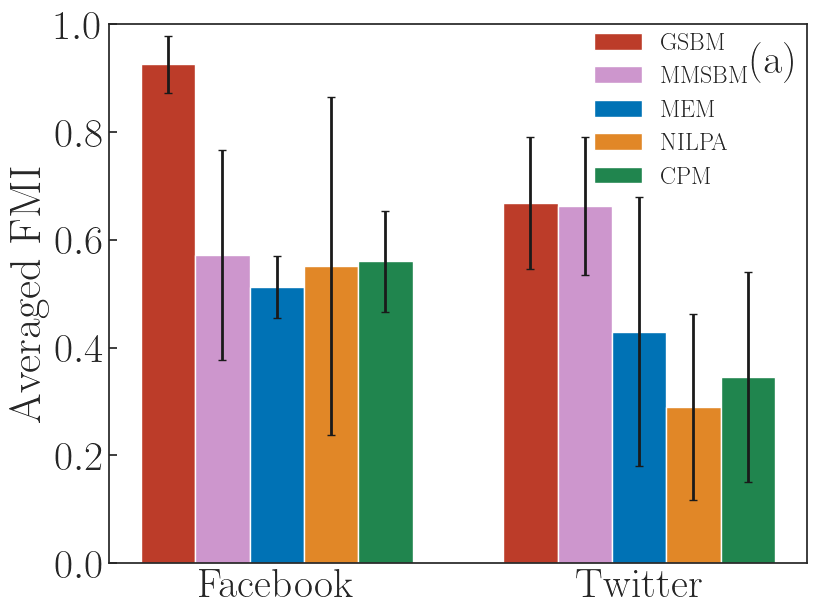

In [131]:
## 新指标FMI
plt.figure(figsize=(9,7))
x_labels = ["Facebook", "Twitter"]
#colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
colorbar = ["#BC3C29FF","#CD96CD", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1
# 生成横坐标范围
x = np.arange(2)
# 生成多柱图
bar_width = 0.15
plt.bar(x + 0.0, plot_mean2[0], color=colorbar[0], alpha=alphabar, width=bar_width, label="GSBM")
plt.errorbar(x + 0.0, plot_mean2[0], yerr=plot_std2[0], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.15, plot_mean2[1], color=colorbar[1], alpha=alphabar, width=bar_width, label="MMSBM")
plt.errorbar(x + 0.15, plot_mean2[1], yerr=plot_std2[1], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.30, plot_mean2[2], color=colorbar[2], alpha=alphabar, width=bar_width, label="MEM")
plt.errorbar(x + 0.30, plot_mean2[2], yerr=plot_std2[2], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.45, plot_mean2[3], color=colorbar[3], alpha=alphabar, width=bar_width, label="NILPA")
plt.errorbar(x + 0.45, plot_mean2[3], yerr=plot_std2[3], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.6, plot_mean2[4], color=colorbar[4], alpha=alphabar, width=bar_width, label="CPM")
plt.errorbar(x + 0.6, plot_mean2[4], yerr=plot_std2[4], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.ylim(0, 1) # 限定左侧Y轴显示尺度范围

plt.xticks(x + 0.3, x_labels) # 横坐标绑定
plt.legend(loc="right", fontsize='x-large', frameon=False, bbox_to_anchor=(0.95, 0.84))
plt.text(1.61, 0.91, '(a)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel(r"Averaged FMI", fontsize = 32)

fig_name = "FMI_egonetworks"
save_file = "E:/学习/研三/Code/Overlapping/" + fig_name + ".jpg"
# plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [114]:
FMI_DBLP_SFMC = [0.5429797469309784, 0.4917793273541404]
FMI_DBLP_SFMC

[0.5429797469309784, 0.4917793273541404]

In [115]:
FMI_DBLP_MMSBM = [0.42334351611423443, 0.4445]
FMI_DBLP_MMSBM

[0.42334351611423443, 0.4445]

In [116]:
FMI_DBLP_GA = [0.4717041034854825, 0.3971682318264949]
FMI_DBLP_GA

[0.4717041034854825, 0.3971682318264949]

In [117]:
FMI_DBLP_LPA = [0.01734821931997666, 0.016476033701661393]
FMI_DBLP_LPA

[0.01734821931997666, 0.016476033701661393]

In [118]:
FMI_DBLP_NILPA = [0.01466818898003742, 0.016468146349687605]
FMI_DBLP_NILPA

[0.01466818898003742, 0.016468146349687605]

In [119]:
FMI_DBLP_CPM = [0.02219039359170067, 0.02582809086296398]
FMI_DBLP_CPM

[0.02219039359170067, 0.02582809086296398]

In [123]:
FMI_DBLP = [FMI_DBLP_SFMC, FMI_DBLP_MMSBM, FMI_DBLP_GA, FMI_DBLP_LPA, FMI_DBLP_CPM]

In [124]:
FMI_DBLP

[[0.5429797469309784, 0.4917793273541404],
 [0.42334351611423443, 0.4445],
 [0.4717041034854825, 0.3971682318264949],
 [0.01734821931997666, 0.016476033701661393],
 [0.02219039359170067, 0.02582809086296398]]

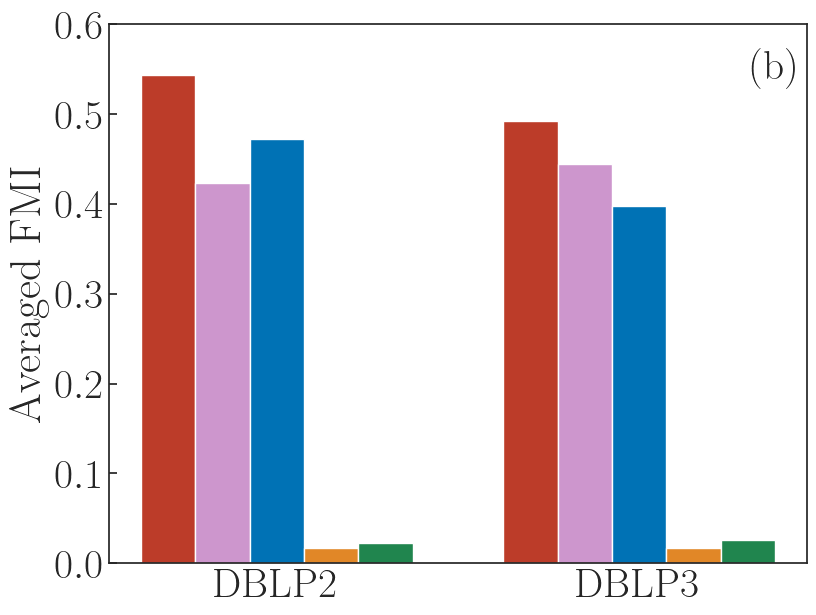

In [130]:
## 新指标FMI
plt.figure(figsize=(9,7))
x_labels = ["DBLP2", "DBLP3"]
colorbar = ["#BC3C29FF", "#CD96CD", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1
# 生成横坐标范围
x = np.arange(2)
# 生成多柱图
bar_width = 0.15
plt.bar(x + 0.0, FMI_DBLP[0], color=colorbar[0], alpha=alphabar, width=bar_width, label="GSBM")
plt.bar(x + 0.15, FMI_DBLP[1], color=colorbar[1], alpha=alphabar, width=bar_width, label="MMSBM")
plt.bar(x + 0.30, FMI_DBLP[2], color=colorbar[2], alpha=alphabar, width=bar_width, label="MEM")
plt.bar(x + 0.45, FMI_DBLP[3], color=colorbar[3], alpha=alphabar, width=bar_width, label="NILPA")
plt.bar(x + 0.60, FMI_DBLP[4], color=colorbar[4], alpha=alphabar, width=bar_width, label="CPM")
plt.ylim(0, 0.6) # 限定左侧Y轴显示尺度范围

plt.xticks(x + 0.3, x_labels) # 横坐标绑定
#plt.legend(loc="upper right", fontsize='x-large')
plt.text(1.61, 0.54, '(b)', fontsize = 30)

#plt.xlabel('Facebook', fontsize = 32)
plt.ylabel('Averaged FMI', fontsize = 32)
x = np.arange(2)
#plt.xticks("DBLP2", "DBLP3")
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

fig_name = "FMI_DBLPnetworks"
save_file = "E:/学习/研三/Code/Overlapping/" + fig_name + ".jpg"
# plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [191]:
method_select = method_name[0]
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook" + select_name_facebook[0]
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[0]
dir_dblp_res = dir_DBLP + "/" + method_select + "_" + "DBLP" + select_name_DBLP[0]
SFMC_dblp_RI = []
for i in select_name_DBLP:
    dir_res = dir_DBLP + "/" + method_select + "_" + i
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    #SFMC_dblp_RI.append(np.max(data_temp[5]))

In [191]:
method_select = method_name[0]
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook" + select_name_facebook[0]
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[0]
dir_dblp_res = dir_DBLP + "/" + method_select + "_" + "DBLP" + select_name_DBLP[0]
SFMC_dblp_RI = []
for i in select_name_DBLP:
    dir_res = dir_DBLP + "/" + method_select + "_" + i
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    #SFMC_dblp_RI.append(np.max(data_temp[5]))

In [84]:
method_select = method_name[2]
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook" + select_name_facebook[0]
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[0]
dir_dblp_res = dir_DBLP + "/" + method_select + "_" + "DBLP" + select_name_DBLP[0]
CPM_dblp_RI = []
for i in select_name_DBLP:
    dir_res = dir_DBLP + "/" + method_select + "_" + i
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    #CPM_dblp_RI.append(np.max(data_temp[5]))

In [204]:
method_select = method_name[2]
dir_facebook_res = dir_facebook + "/" + method_select + "_" + "facebook" + select_name_facebook[0]
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[0]
dir_dblp_res = dir_DBLP + "/" + method_select + "_" + "DBLP" + select_name_DBLP[0]
LPA_dblp_RI = []
for i in select_name_DBLP:
    dir_res = dir_DBLP + "/" + method_select + "_" + i
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    LPA_dblp_RI.append(np.max(data_temp[1]))

In [7]:
method_select = method_name[2]
dir_twitter_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[0]
for i in select_name_DBLP:
    dir_res = dir_DBLP + "/" + method_select + "_" + i
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    LPA_dblp_RI.append(np.max(data_temp[1]))

In [210]:
data_temp = pickle.load(open(dir_facebook + "/" + "LPA" + "_" + "facebook" + select_name_facebook[0] + '.pkl','rb'))

In [215]:
dir_facebook + "/" + "LPA" + "_" + "facebook" + select_name_facebook[0]

'E:/学习/研三/Code/Overlapping/facebook/LPA_facebook1912'

In [214]:
data_temp[2]

[[6],
 [7],
 [7],
 [6],
 [6],
 [6],
 [5],
 [5],
 [5],
 [5],
 [5],
 [5],
 [5],
 [6],
 [5],
 [7],
 [6],
 [6],
 [5],
 [5],
 [5],
 [5],
 [7],
 [6],
 [7],
 [5],
 [5],
 [6],
 [5],
 [6],
 [5],
 [7],
 [5],
 [7],
 [5],
 [5],
 [5],
 [5],
 [6],
 [5],
 [5],
 [7],
 [0],
 [5],
 [5],
 [6],
 [5],
 [7],
 [5],
 [6],
 [5],
 [7],
 [7],
 [5],
 [5],
 [5],
 [5],
 [6],
 [7],
 [6],
 [7],
 [7],
 [5],
 [6],
 [6],
 [6],
 [5],
 [6],
 [5],
 [5],
 [6],
 [5],
 [6],
 [6],
 [7],
 [5],
 [6],
 [6],
 [5],
 [6],
 [7],
 [6],
 [5],
 [6],
 [7],
 [7],
 [7],
 [7],
 [6],
 [5],
 [5],
 [0],
 [6],
 [5],
 [7],
 [6],
 [6],
 [6],
 [7],
 [5],
 [7],
 [6],
 [6],
 [5],
 [6],
 [6],
 [6],
 [5],
 [6],
 [5],
 [6],
 [7],
 [6],
 [6],
 [7],
 [6],
 [5],
 [5],
 [6],
 [0],
 [5],
 [6],
 [5],
 [6],
 [5],
 [5],
 [5],
 [5],
 [6],
 [6],
 [7],
 [7],
 [5],
 [7],
 [6],
 [5],
 [5],
 [7],
 [5],
 [7],
 [5],
 [6],
 [6],
 [5],
 [6],
 [6],
 [7],
 [6],
 [7],
 [5],
 [6],
 [5],
 [5],
 [6],
 [7],
 [5],
 [5],
 [5],
 [6],
 [6],
 [5],
 [6],
 [6],
 [6],
 [5],
 [5],
 [7]

In [49]:
method_select = method_name[1]
method_select

'LPA'

In [50]:
nodes_num_all = []
average_degree_all = []
mu_all = []
for i in range(len(select_name_twitter)):
    dir_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[i]
    data_temp = pickle.load(open(dir_res + '.pkl','rb'))
    A = data_temp[2]
    nodes_num = len(A)
    degree_list = np.sum(A, axis=0)
    average_degree = np.mean(degree_list)
    mu = (np.sum(data_temp[1])-nodes_num) / nodes_num
    
    nodes_num_all.append(nodes_num)
    average_degree_all.append(average_degree)
    mu_all.append(mu)
    print(nodes_num)
    print(degree_list)
    print(np.sum(data_temp[1]))

94
2914
95
3054
63
1650
157
6130
60
544
81
5002
192
2668
114
7152


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [53]:
np.mean(nodes_num_all), np.std(nodes_num_all)

(107.0, 43.16827538829875)

In [56]:
np.mean(average_degree_all), np.std(average_degree_all)

(0.48946596652292856, 0.9773318687771118)

In [55]:
np.mean(mu_all), np.std(mu_all)

(33.479357390475776, 18.435424507238114)

In [58]:
dir_res = dir_twitter + "/" + method_select + "_" + "twitter" + select_name_twitter[0]
data_temp = pickle.load(open(dir_res + '.pkl','rb'))

In [69]:
SFMC_facebook_RI = [0.7937467539212631, 0.7277021498177489, 0.9711112943569445]
SFMC_facebook_RI

[0.7937467539212631, 0.7277021498177489, 0.9711112943569445]

In [70]:
GA_facebook_RI = [0.12111976732107612, 0.7073941828460909, 0.03444105439652567]
GA_facebook_RI

[0.12111976732107611, 0.7073941828460909, 0.03444105439652567]

In [71]:
LPA_facebook_RI = [0.6777189155500156, 0.5629695752436212, 0.9794398174871499]
LPA_facebook_RI

[0.6777189155500156, 0.5629695752436212, 0.9794398174871499]

In [72]:
CPM_facebook_RI = [0.39992300947411197, 0.4589208652868255, 0.05719331048093901]
CPM_facebook_RI

[0.39992300947411197, 0.4589208652868255, 0.05719331048093901]

In [73]:
SFMC_twitter_RI = [0.1682256420975623,
 0.18202257449698134,
 0.5975422427035331,
 0.44862298195631534,
 0.7090418353576249,
 0.25022421524663674,
 0.6866228070175439,
 0.19058952764555104,
 0.6648882960986996]
SFMC_twitter_RI

[0.1682256420975623,
 0.18202257449698134,
 0.5975422427035331,
 0.44862298195631534,
 0.7090418353576249,
 0.25022421524663674,
 0.6866228070175439,
 0.19058952764555104,
 0.6648882960986996]

In [74]:
GA_twitter_RI = [0.16356177984479925,
0.15228084591593338,
0.3689196108550947,
0.6129154795821463,
0.307125062282013,
0.4866228070175439,
0.2891797876235811,
0.6133155496276537
]
GA_twitter_RI

[0.16356177984479925,
 0.15228084591593338,
 0.3689196108550947,
 0.6129154795821463,
 0.307125062282013,
 0.4866228070175439,
 0.2891797876235811,
 0.6133155496276537]

In [75]:
LPA_twitter_RI = [0.16055705066234682,
 0.050958103650951214,
 0.5,
 0.7131054131054131,
 0.17638266068759345,
 0.638157894736842,
 0.31636763090443065,
 0.7159053017672558]
LPA_twitter_RI

[0.16055705066234682,
 0.050958103650951214,
 0.5,
 0.7131054131054131,
 0.17638266068759345,
 0.638157894736842,
 0.31636763090443065,
 0.7159053017672558]

In [76]:
CPM_twitter_RI = [0.05232147989444258, 
                 0.04882391207587222, 
                 0.5, 
                 0.7011396011396012, 
                 0.17638266068759345, 
                 0.5554824561403509, 
                 0.31636763090443065, 
                 0.5953095476269867]
CPM_twitter_RI

[0.05232147989444258,
 0.04882391207587222,
 0.5,
 0.7011396011396012,
 0.17638266068759345,
 0.5554824561403509,
 0.31636763090443065,
 0.5953095476269867]

In [41]:
facebook_mean = []
facebook_mean.append(np.mean(SFMC_facebook_RI))
facebook_mean.append(np.mean(GA_facebook_RI))
facebook_mean.append(np.mean(LPA_facebook_RI))
facebook_mean.append(np.mean(CPM_facebook_RI))

facebook_std = []
facebook_std.append(np.std(SFMC_facebook_RI))
facebook_std.append(np.std(GA_facebook_RI))
facebook_std.append(np.std(LPA_facebook_RI))
facebook_std.append(np.std(CPM_facebook_RI))

In [42]:
twitter_mean = []
twitter_mean.append(np.mean(SFMC_twitter_RI))
twitter_mean.append(np.mean(GA_twitter_RI))
twitter_mean.append(np.mean(LPA_twitter_RI))
twitter_mean.append(np.mean(CPM_twitter_RI))

twitter_std = []
twitter_std.append(np.std(SFMC_twitter_RI))
twitter_std.append(np.std(GA_twitter_RI))
twitter_std.append(np.std(LPA_twitter_RI))
twitter_std.append(np.std(CPM_twitter_RI))

In [43]:
facebook_mean = [np.mean(SFMC_facebook_RI), np.mean(GA_facebook_RI), np.mean(LPA_facebook_RI), np.mean(CPM_facebook_RI)]
facebook_std = [np.std(SFMC_facebook_RI), np.std(GA_facebook_RI), np.std(LPA_facebook_RI), np.std(CPM_facebook_RI)]

twitter_mean = [np.mean(SFMC_twitter_RI), np.mean(GA_twitter_RI), np.mean(LPA_twitter_RI), np.mean(CPM_twitter_RI)]
twitter_std = [np.std(SFMC_twitter_RI), np.std(GA_twitter_RI), np.std(LPA_twitter_RI), np.std(CPM_twitter_RI)]

In [44]:
plot_mean = [np.mean(SFMC_facebook_RI), np.mean(GA_facebook_RI), np.mean(LPA_facebook_RI), np.mean(CPM_facebook_RI),
            np.mean(SFMC_twitter_RI), np.mean(GA_twitter_RI), np.mean(LPA_twitter_RI), np.mean(CPM_twitter_RI)]
plot_std = [np.std(SFMC_facebook_RI), np.std(GA_facebook_RI), np.std(LPA_facebook_RI), np.std(CPM_facebook_RI),
           np.std(SFMC_twitter_RI), np.std(GA_twitter_RI), np.std(LPA_twitter_RI), np.std(CPM_twitter_RI)]

In [45]:
plot_mean = [facebook_mean, twitter_mean]
plot_std = [facebook_std, twitter_std]

In [46]:
plot_mean2 = np.transpose(plot_mean)
plot_mean2

array([[0.8308534 , 0.43308668],
       [0.28765167, 0.37424012],
       [0.74004277, 0.40892926],
       [0.30534573, 0.36822841]])

In [47]:
plot_std2 = np.transpose(plot_std)
plot_std2

array([[0.10277704, 0.22283001],
       [0.29890482, 0.17035703],
       [0.1756418 , 0.25001869],
       [0.1771156 , 0.23878188]])

In [48]:
[i for i in range(0, 100, 10)]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

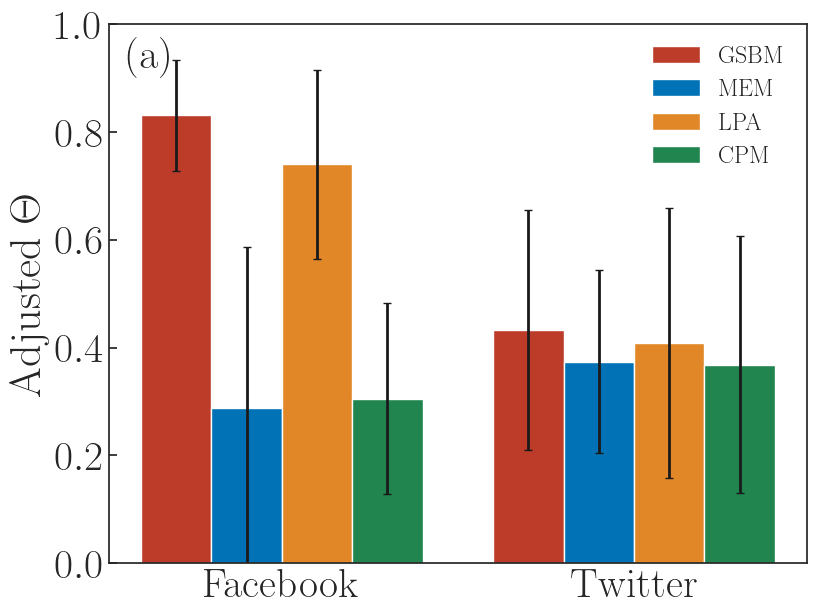

In [49]:
## 新指标ARC
plt.figure(figsize=(9,7))
x_labels = ["Facebook", "Twitter"]
#colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1
# 生成横坐标范围
x = np.arange(2)
# 生成多柱图
bar_width = 0.2
plt.bar(x + 0.0, plot_mean2[0], color=colorbar[0], alpha=alphabar, width=bar_width, label="GSBM")
plt.errorbar(x + 0.0, plot_mean2[0], yerr=plot_std2[0], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.2, plot_mean2[1], color=colorbar[1], alpha=alphabar, width=bar_width, label="MEM")
plt.errorbar(x + 0.2, plot_mean2[1], yerr=plot_std2[1], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.4, plot_mean2[2], color=colorbar[2], alpha=alphabar, width=bar_width, label="LPA")
plt.errorbar(x + 0.4, plot_mean2[2], yerr=plot_std2[2], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.6, plot_mean2[3], color=colorbar[3], alpha=alphabar, width=bar_width, label="CPM")
plt.errorbar(x + 0.6, plot_mean2[3], yerr=plot_std2[3], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.ylim(0, 1) # 限定左侧Y轴显示尺度范围

plt.xticks(x + 0.3, x_labels) # 横坐标绑定
plt.legend(loc="upper right", fontsize='x-large', frameon=False)
plt.text(-0.14, 0.92, '(a)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel(r"Adjusted $\Theta$", fontsize = 32)

fig_name = "egonetworks"
save_file = "E:/学习/研三/Code/Overlapping/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

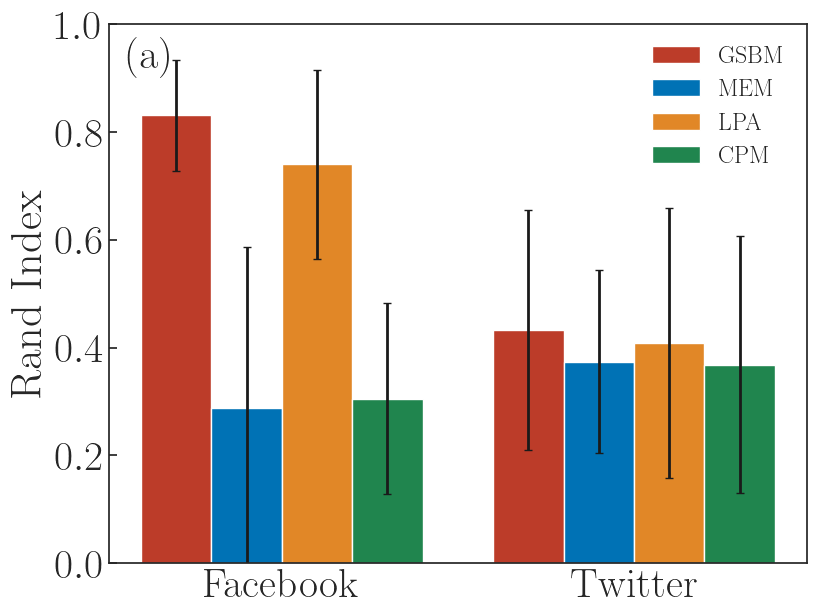

In [56]:
plt.figure(figsize=(9,7))
x_labels = ["Facebook", "Twitter"]
#colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1
# 生成横坐标范围
x = np.arange(2)
# 生成多柱图
bar_width = 0.2
plt.bar(x + 0.0, plot_mean2[0], color=colorbar[0], alpha=alphabar, width=bar_width, label="GSBM")
plt.errorbar(x + 0.0, plot_mean2[0], yerr=plot_std2[0], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.2, plot_mean2[1], color=colorbar[1], alpha=alphabar, width=bar_width, label="MEM")
plt.errorbar(x + 0.2, plot_mean2[1], yerr=plot_std2[1], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.4, plot_mean2[2], color=colorbar[2], alpha=alphabar, width=bar_width, label="LPA")
plt.errorbar(x + 0.4, plot_mean2[2], yerr=plot_std2[2], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.6, plot_mean2[3], color=colorbar[3], alpha=alphabar, width=bar_width, label="CPM")
plt.errorbar(x + 0.6, plot_mean2[3], yerr=plot_std2[3], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.ylim(0, 1) # 限定左侧Y轴显示尺度范围

plt.xticks(x + 0.3, x_labels) # 横坐标绑定
plt.legend(loc="upper right", fontsize='x-large', frameon=False)
plt.text(-0.14, 0.92, '(a)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel(r"Rand Index", fontsize = 32)

fig_name = "egonetworks"
save_file = "E:/学习/研三/Code/Overlapping/" + fig_name + ".jpg"
#plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

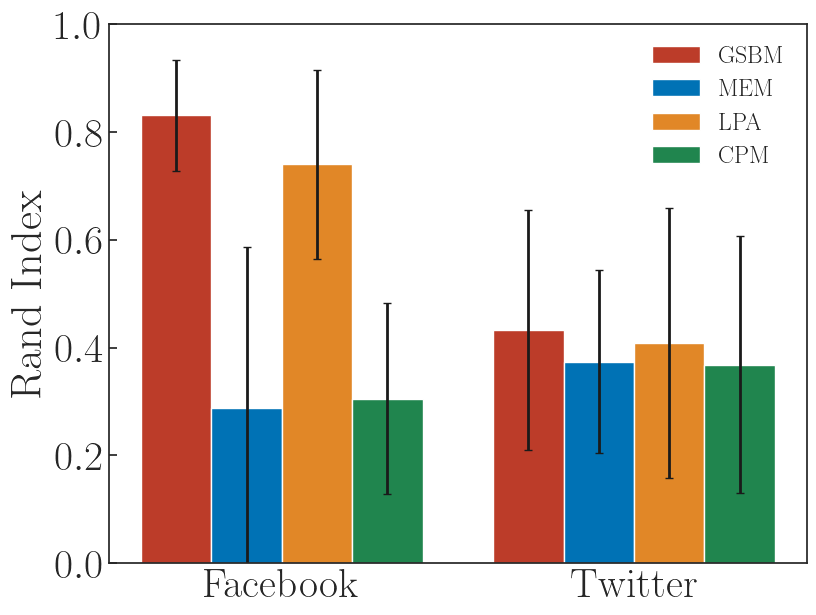

In [21]:
## 大论文用
plt.figure(figsize=(9,7))
x_labels = ["Facebook", "Twitter"]
#colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1
# 生成横坐标范围
x = np.arange(2)
# 生成多柱图
bar_width = 0.2
plt.bar(x + 0.0, plot_mean2[0], color=colorbar[0], alpha=alphabar, width=bar_width, label="GSBM")
plt.errorbar(x + 0.0, plot_mean2[0], yerr=plot_std2[0], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.2, plot_mean2[1], color=colorbar[1], alpha=alphabar, width=bar_width, label="MEM")
plt.errorbar(x + 0.2, plot_mean2[1], yerr=plot_std2[1], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.4, plot_mean2[2], color=colorbar[2], alpha=alphabar, width=bar_width, label="LPA")
plt.errorbar(x + 0.4, plot_mean2[2], yerr=plot_std2[2], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.bar(x + 0.6, plot_mean2[3], color=colorbar[3], alpha=alphabar, width=bar_width, label="CPM")
plt.errorbar(x + 0.6, plot_mean2[3], yerr=plot_std2[3], capsize=3, elinewidth=2, fmt=' k,')  #添加误差棒
plt.ylim(0, 1) # 限定左侧Y轴显示尺度范围

plt.xticks(x + 0.3, x_labels) # 横坐标绑定
plt.legend(loc="upper right", fontsize='x-large', frameon=False)
#plt.text(-0.14, 0.92, '(a)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel(r"Rand Index", fontsize = 32)

fig_name = "egonetworks"
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [26]:
SFMC_dblp_RI = [0.21855413180404466, 0.15463005574694885]
SFMC_dblp_RI

[0.21855413180404465, 0.15463005574694885]

In [27]:
GA_dblp_RI = [0.01542441356265916, 0.02747324010711849]
GA_dblp_RI

[0.01542441356265916, 0.02747324010711849]

In [28]:
LPA_dblp_RI = [0.3033572715342888, 0.1375093987543671]
LPA_dblp_RI

[0.3033572715342888, 0.1375093987543671]

In [29]:
CPM_dblp_RI = [0.12263905745931447, 0.17363397640627742]
CPM_dblp_RI

[0.12263905745931447, 0.17363397640627742]

In [30]:
dblp_RI = [SFMC_dblp_RI, GA_dblp_RI, LPA_dblp_RI, CPM_dblp_RI]

In [31]:
dblp_RI

[[0.21855413180404465, 0.15463005574694885],
 [0.01542441356265916, 0.02747324010711849],
 [0.3033572715342888, 0.1375093987543671],
 [0.12263905745931447, 0.17363397640627742]]

In [60]:
def read_txt(dir_txt):
    with open(dir_txt, 'r', encoding='utf-8') as infile:
        # 第一种：读取所有行circle0	828	830	708	713	840	803	747	774	823	745	856	697	719
        #data1 = infile.readlines()
        #print(data1)
        # 输出：['1 2 3 4 5\n', '6 7 8 9 10']

        # 第二种：每行分开读取
        data2 = []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分
            #print(data_line)
            data2.append([int(i) for i in data_line])
        #print(data2)
        # 输出：[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

        # 第三种：每个字符分开读取
        data = copy.deepcopy(data2)
        for i in range(len(data2)):
            for j in range(len(data2[i])):
                data[i][j] = data2[i][j]
        #print(data)
    return data

def read_circle(dir_txt):
    with open(dir_txt, 'r', encoding='utf-8') as infile:
        # 第一种：读取所有行circle0	828	830	708	713	840	803	747	774	823	745	856	697	719
        #data1 = infile.readlines()
        #print(data1)
        # 输出：['1 2 3 4 5\n', '6 7 8 9 10']

        # 第二种：每行分开读取
        data2 = []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分
            #print(data_line)
            data2.append([i for i in data_line])
        #print(data2)
        # 输出：[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

        # 第三种：每个字符分开读取
        data = copy.deepcopy(data2)
        for i in range(len(data2)):
            for j in range(len(data2[i])):
                data[i][j] = data2[i][j]
        #print(data)
    return data

def read_dataset_info(name):
    '''
    点对之间的连边信息
    社团列表，每个社团中包含的节点
    每个社团的大小
    '''
    ## 读取特征信息（节点数）
    #dir_feat = dir_facebooktxt + "/" + name + "feat.txt"
    #feat_temp = read_txt(dir_feat)
    #feat_min = feat_temp[0][0]
    #nodes_num = len(feat_temp)

    ## 读取连边信息
    dir_edge = dir_twittertxt + "/" + name + "edges.txt"
    edge0 = read_txt(dir_edge)
    #edge_temp = [[i-feat_min for i in j] for j in edge0]
    
    ## 读取社团信息
    dir_circle = dir_twittertxt + "/" + name + "circles.txt"
    circle_temp = read_circle(dir_circle)
    [i.pop(0) for i in circle_temp]

    community_list = [np.array(i).astype(int) for i in circle_temp]    # 每个list代表一个社团
    community_size_list = [len(i) for i in community_list]             # 每个社团大小
    return edge0, community_list, community_size_list

def read_dataset_info1(name):
    '''
    点对之间的连边信息
    社团列表，每个社团中包含的节点
    每个社团的大小
    '''
    ## 读取特征信息（节点数）
    #dir_feat = dir_facebooktxt + "/" + name + "feat.txt"
    #feat_temp = read_txt(dir_feat)
    #feat_min = feat_temp[0][0]
    #nodes_num = len(feat_temp)

    ## 读取连边信息
    dir_edge = "./" + name + "edges.txt"
    edge0 = read_txt(dir_edge)
    #edge_temp = [[i-feat_min for i in j] for j in edge0]
    
    ## 读取社团信息
    dir_circle = "./" + name + "circles.txt"
    circle_temp = read_circle(dir_circle)
    [i.pop(0) for i in circle_temp]

    community_list = [np.array(i).astype(int) for i in circle_temp]    # 每个list代表一个社团
    community_size_list = [len(i) for i in community_list]             # 每个社团大小
    return edge0, community_list, community_size_list


def community_clean(community_size_list, community_size_filter):
    '''
    筛选后的社团列表，每个小列表中即为社团拥有的点
    筛选后的节点
    重叠节点大小
    '''
    ## 筛选出符合条件的社团位置，仅对符合条件社团中的节点进行分析
    community_select_loc = np.where(np.array(community_size_list) > community_size_filter)[0]   # 筛选出的社团位置
    community_select = list(np.array(community_list)[community_select_loc])                     # 外层list，内层array
    community_select = [list(i) for i in community_select]                                     # 均为list

    ## 筛选节点
    nodes_select_all = sum(community_select, [])             # 所有出现在社团中的节点数量
    nodes_select = np.array(list(set(nodes_select_all)))     # 筛选出的节点编号
    mu = 1 - len(nodes_select) / len(nodes_select_all)
    return community_select, nodes_select, mu

def df_clean(df, remove_array):
    df = df.drop(labels=remove_array, axis=0)
    df = df.drop(labels=remove_array, axis=1)
    return df


dir_empirical = "E:/学习/研三/Dataset"
dir_twitter = dir_empirical + "/" + "twitter"
dir_twittertxt = dir_empirical + "/" + "twittertxt"


select_name = np.array(['229741646', '230601773', '30207757', '16809036', 
       '73025843', '17396702', '19898730', '63207451'])



'''
对其中某个网络（数据集）进行实验
'''

TW_DD_list = []

for i in range(8):
    ## 读取数据并初始化
    # for name_ind  in range(len(select_name)):
    name = select_name[i]
    edge0, community_list, community_size_list = read_dataset_info(name)
    community_size_filter = 60
    community_select, nodes_select, mu = community_clean(community_size_list, community_size_filter)

    nodes_num = len(nodes_select)

    A_num = len(nodes_select)
    A_temp = np.zeros([A_num, A_num]).astype(int)
    for _ in edge0:
        if _[0] in nodes_select and _[1] in nodes_select:
            i = np.where(nodes_select == _[0])[0][0]
            j = np.where(nodes_select == _[1])[0][0]
            A_temp[i][j] = 1
            A_temp[j][i] = 1
    TW_DD_list.append(np.sum(A_temp, axis=0))

<ipython-input-60-f7f664943007>:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  community_select = list(np.array(community_list)[community_select_loc])                     # 外层list，内层array


In [68]:
TW_label_list = ['Twitter 229741646',
                 'Twitter 230601773',
                 'Twitter 30207757',
                 'Twitter 16809036', 
                 'Twitter 73025843', 
                 'Twitter 17396702', 
                 'Twitter 19898730', 
                 'Twitter 63207451']

<Figure size 900x700 with 0 Axes>

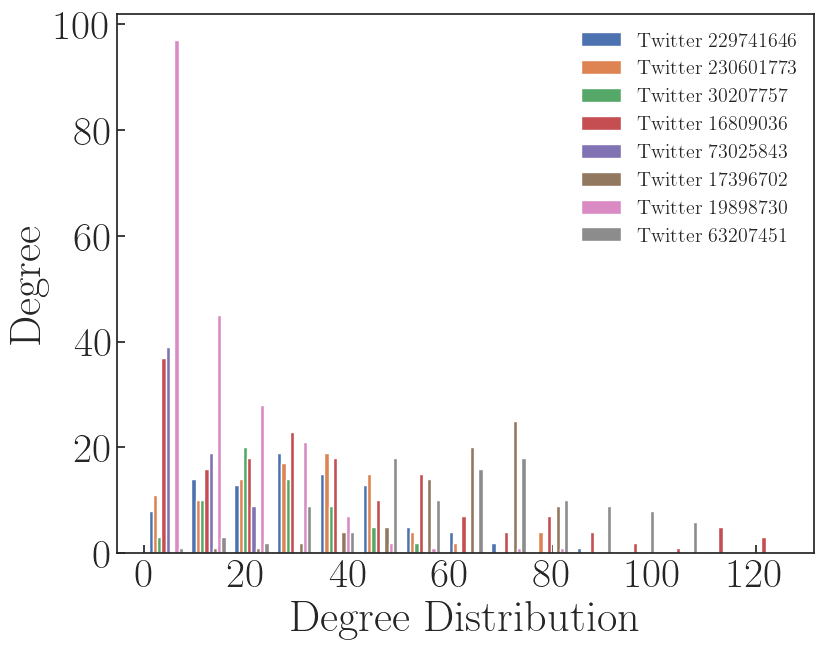

In [69]:
plt.figure(figsize=(9,7))
plt.hist(TW_DD_list, bins=15, label=TW_label_list)
#plt.hist(degree_A3, bins=100, stacked=True)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r"Degree Distribution", fontsize = 32)
plt.ylabel(r"Degree", fontsize = 32)

plt.legend(loc="upper right", fontsize='large', frameon=False)

# plt.xlim(0, 250)
# x_major_locator=MultipleLocator(50)       # 把x轴的刻度间隔设置为1，并存在变量里
# y_major_locator=MultipleLocator(5)    # 把y轴的刻度间隔设置为10，并存在变量里
# ax=plt.gca()               # ax为两条坐标轴的实例
# ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
# ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

fig_name = "Degree_Distribution_Twitter"
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [42]:
def read_txt(dir_txt):
    with open(dir_txt, 'r', encoding='utf-8') as infile:
        # 第一种：读取所有行circle0	828	830	708	713	840	803	747	774	823	745	856	697	719
        #data1 = infile.readlines()
        #print(data1)
        # 输出：['1 2 3 4 5\n', '6 7 8 9 10']

        # 第二种：每行分开读取
        data2 = []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分
            #print(data_line)
            data2.append([int(i) for i in data_line])
        #print(data2)
        # 输出：[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

        # 第三种：每个字符分开读取
        data = copy.deepcopy(data2)
        for i in range(len(data2)):
            for j in range(len(data2[i])):
                data[i][j] = data2[i][j]
        #print(data)
    return data


def read_circle(dir_txt):
    with open(dir_txt, 'r', encoding='utf-8') as infile:
        # 第一种：读取所有行circle0	828	830	708	713	840	803	747	774	823	745	856	697	719
        #data1 = infile.readlines()
        #print(data1)
        # 输出：['1 2 3 4 5\n', '6 7 8 9 10']

        # 第二种：每行分开读取
        data2 = []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分
            #print(data_line)
            data2.append([i for i in data_line])
        #print(data2)
        # 输出：[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

        # 第三种：每个字符分开读取
        data = copy.deepcopy(data2)
        for i in range(len(data2)):
            for j in range(len(data2[i])):
                data[i][j] = data2[i][j]
        #print(data)
    return data

def read_dataset_info(name):
    '''
    点对之间的连边信息
    社团列表，每个社团中包含的节点
    每个社团的大小
    '''
    ## 读取特征信息（节点数）
    #dir_feat = dir_facebooktxt + "/" + name + "feat.txt"
    #feat_temp = read_txt(dir_feat)
    #feat_min = feat_temp[0][0]
    #nodes_num = len(feat_temp)

    ## 读取连边信息
    dir_edge = dir_facebooktxt + "/" + name + "edges.txt"
    edge0 = read_txt(dir_edge)
    #edge_temp = [[i-feat_min for i in j] for j in edge0]
    
    ## 读取社团信息
    dir_circle = dir_facebooktxt + "/" + name + "circles.txt"
    circle_temp = read_circle(dir_circle)
    [i.pop(0) for i in circle_temp]

    community_list = [np.array(i).astype(int) for i in circle_temp]    # 每个list代表一个社团
    community_size_list = [len(i) for i in community_list]             # 每个社团大小
    return edge0, community_list, community_size_list

def community_clean(community_size_list, community_size_filter):
    '''
    筛选后的社团列表，每个小列表中即为社团拥有的点
    筛选后的节点
    重叠节点大小
    '''
    ## 筛选出符合条件的社团位置，仅对符合条件社团中的节点进行分析
    community_select_loc = np.where(np.array(community_size_list) > community_size_filter)[0]   # 筛选出的社团位置
    community_select = list(np.array(community_list)[community_select_loc])                     # 外层list，内层array
    community_select = [list(i) for i in community_select]                                     # 均为list

    ## 筛选节点
    nodes_select_all = sum(community_select, [])             # 所有出现在社团中的节点数量
    nodes_select = np.array(list(set(nodes_select_all)))     # 筛选出的节点编号
    mu = 1 - len(nodes_select) / len(nodes_select_all)
    return community_select, nodes_select, mu

def df_clean(df, remove_array):
    df = df.drop(labels=remove_array, axis=0)
    df = df.drop(labels=remove_array, axis=1)
    return df



dir_empirical = "E:/学习/研三/Dataset"
dir_facebook = dir_empirical + "/" + "facebook"
dir_facebooktxt = dir_empirical + "/" + "facebooktxt"
# dir_gplus = dir_empirical + "/" + "gplustxt"

select_name_facebook = np.array(['1912','1684', '348'])

## 读取数据并初始化
#for name_ind  in range(6, len(select_name1)):
name = select_name_facebook[2]
edge0, community_list, community_size_list = read_dataset_info(name)
community_size_filter = 100
community_select, nodes_select, mu = community_clean(community_size_list, community_size_filter)

nodes_num = len(nodes_select)

A_num = len(nodes_select)
A_temp = np.zeros([A_num, A_num]).astype(int)
for _ in edge0:
    if _[0] in nodes_select and _[1] in nodes_select:
        i = np.where(nodes_select == _[0])[0][0]
        j = np.where(nodes_select == _[1])[0][0]
        A_temp[i][j] = 1
        A_temp[j][i] = 1

<ipython-input-42-746a32d168b6>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  community_select = list(np.array(community_list)[community_select_loc])                     # 外层list，内层array


In [39]:
FB_A0 = copy.deepcopy(A_temp)

In [41]:
FB_A1 = copy.deepcopy(A_temp)

In [43]:
FB_A2 = copy.deepcopy(A_temp)

In [46]:
FB_DD0 = np.sum(FB_A0, axis=0)
FB_DD1 = np.sum(FB_A1, axis=0)
FB_DD2 = np.sum(FB_A2, axis=0)

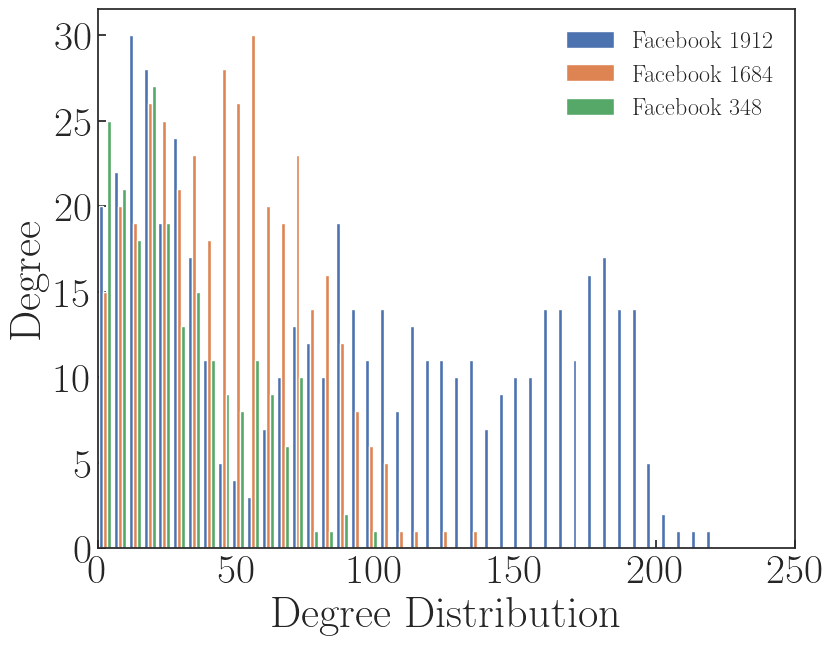

In [62]:
plt.figure(figsize=(9,7))
plt.hist([FB_DD0, FB_DD1, FB_DD2], bins=50, label=['Facebook 1912', 'Facebook 1684', 'Facebook 348'])
#plt.hist(degree_A3, bins=100, stacked=True)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r"Degree Distribution", fontsize = 32)
plt.ylabel(r"Degree", fontsize = 32)

plt.legend(loc="upper right", fontsize='x-large', frameon=False)

plt.xlim(0, 250)
x_major_locator=MultipleLocator(50)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(5)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

fig_name = "Degree_Distribution_Facebook"
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [9]:
def read_txt(dir_txt):
    with open(dir_txt, 'r', encoding='utf-8') as infile:
        # 第一种：读取所有行circle0	828	830	708	713	840	803	747	774	823	745	856	697	719
        #data1 = infile.readlines()
        #print(data1)
        # 输出：['1 2 3 4 5\n', '6 7 8 9 10']

        # 第二种：每行分开读取
        data2 = []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分
            #print(data_line)
            data2.append([int(i) for i in data_line])
        #print(data2)
        # 输出：[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

        # 第三种：每个字符分开读取
        data = copy.deepcopy(data2)
        for i in range(len(data2)):
            for j in range(len(data2[i])):
                data[i][j] = data2[i][j]
        #print(data)
    return data

def read_dblp_community(dir_txt):
    with open(dir_txt, 'r', encoding='utf-8') as infile:
        # 第一种：读取所有行circle0	828	830	708	713	840	803	747	774	823	745	856	697	719
        #data1 = infile.readlines()
        #print(data1)
        # 输出：['1 2 3 4 5\n', '6 7 8 9 10']

        # 第二种：每行分开读取
        data2 = []
        for line in infile:
            data_line = line.strip("\n").split()  # 去除首尾换行符，并按空格划分
            #print(data_line)
            data2.append([float(i) for i in data_line])
        #print(data2)
        # 输出：[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]

        # 第三种：每个字符分开读取
        data = copy.deepcopy(data2)
        for i in range(len(data2)):
            for j in range(len(data2[i])):
                data[i][j] = data2[i][j]
        #print(data)
    return data

def dblp_network_info(dblp_ind):
    dir_dblp_community = r"E:/学习/研三/Dataset/coauthorship" + "/DBLP" + str(dblp_ind) + "_community.txt"
    dir_dblp_edge = r"E:/学习/研三/Dataset/coauthorship" + "/DBLP" + str(dblp_ind) + "_adjacency.txt"

    community_list0 = read_dblp_community(dir_dblp_community)
    community_list = [[int(i[0]), int(i[1])] for i in community_list0]
    nodes_num = np.max([i[0] for i in community_list])
    community_num = np.max([i[1] for i in community_list])

    Zc = np.zeros([nodes_num, community_num]).astype(int)
    for i in community_list:
        node = i[0]-1
        community = i[1]-1
        Zc[node][community] = 1

    edge_list = read_txt(dir_dblp_edge)
    nodes_num = int(np.max(community_list))
    A = np.zeros([nodes_num, nodes_num]).astype(int)
    for i in edge_list:
        A[i[0]-1][i[1]-1] = 1
        A[i[1]-1][i[0]-1] = 1

    return Zc, A


dblp_ind = 2
dblp_community2, dblp_A2 = dblp_network_info(dblp_ind)

dblp_ind = 3
dblp_community3, dblp_A3 = dblp_network_info(dblp_ind)

In [13]:
degree_A2 = np.sum(dblp_A2, axis=0)
degree_A3 = np.sum(dblp_A3, axis=0)

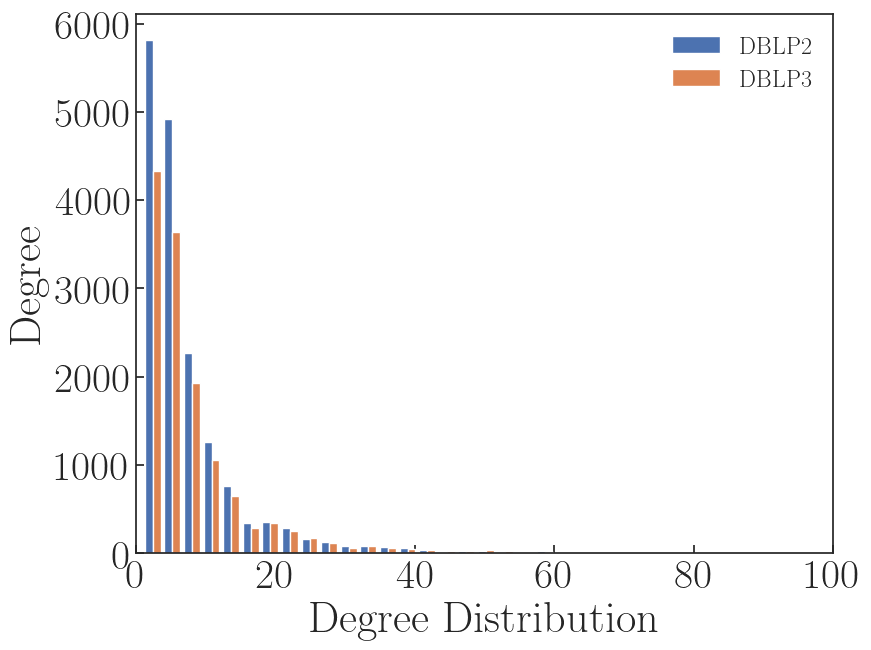

In [36]:
plt.figure(figsize=(9,7))
plt.hist([degree_A2, degree_A3], bins=100, label=['DBLP2', 'DBLP3'])
#plt.hist(degree_A3, bins=100, stacked=True)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r"Degree Distribution", fontsize = 32)
plt.ylabel(r"Degree", fontsize = 32)

plt.legend(loc="upper right", fontsize='x-large', frameon=False)

plt.xlim(0, 100)
x_major_locator=MultipleLocator(20)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(1000)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

fig_name = "Degree_Distribution_DBLP"
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

## Averaged FMI

In [127]:
'''
小论文中的测试集，需要对比3个算法
'''
## 初始化
seed = 19980210
size = [1000,1000]
overlap_ratio = 0.1
p = 0.03            # 社团内部连接概率
q = 0.01            # 社团之间连接概率
niter = 10
vsteps = 100
trial = 1
beta1 = 1.0
beta2 = 1.0
xi = 1.0
repeat = 1
knowp = True

In [128]:
R = np.diag(size)
K = R.shape[0]
n = np.sum(R)
overlap_size = overlap_ratio * n
c = np.repeat(np.arange(K), np.sum(R, axis=0))
#overlap_num = 10
#c[int(n/2 - overlap_num/2): int(n/2)] = 2
#c[-int(overlap_num/2):] = 2

In [129]:
## 将组标签扩展，得到节点数*组数的矩阵，每行代表一个节点，第几个位置为1即分为第几组
## 返回结果：每个节点都是一个数组，属于的组为1，其余为0
def Zform(e, K):
    n = len(e)  #e是节点的分组列表community assgnment，n即为网络大小，共n个节点
    Ze = np.zeros((n, K))  #生成n*K的0矩阵（初始矩阵）
    Ze[np.arange(n), e] = 1  #对每个节点（每行）打标签
    return Ze

In [130]:
## 根据连边概率生成邻接矩阵A
def genA_2communities():
    #Zc = Zform(c, K)  #输入c和组数K，得到扩展的分组矩阵
    Zc = Zform(c, K)
    avg_n = int(n/K)
    avg_overlap = int(overlap_size/K)
    for i in range(avg_n - avg_overlap, avg_n):
        Zc[i][1] = 1
    for i in range(avg_n*K - avg_overlap, avg_n*K):
        Zc[i][0] = 1
    #Omega = np.matmul(np.matmul(Zc, Pstar), np.transpose(Zc))  #Pstar为转移矩阵（p和q未知的情况下，非平衡sbm）
    Omega = np.matmul(Zc, np.transpose(Zc))
    Omega[Omega > 0] = p
    Omega[Omega == 0] = q
    A = np.random.binomial(1, Omega)  #二项分布中采样1个数，Omega为取“正”的概率
    tmp = np.triu(A) - np.diag(np.diag(A))  #A的右上三角阵减去A的特征值
    A = tmp + np.transpose(tmp)
    return A, Zc

In [131]:
A, Zc = genA_2communities()

In [132]:
ZcT = np.transpose(Zc)
ZcT

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [52]:
pkl_number = repeat = 1

In [ ]:
repeat_mark = 49
file_name = "PGP_LPA" + "v" + str(9) + "iter" + str(400) + "repeat" + str(repeat_mark)
file_dir = "E:/学习/研三/Code/Overlapping/recurrent/" + file_name

In [179]:
dir_SFMC = "E:/学习/研三/Code/Overlapping/compare_SFMC"
dir_GA = "E:/学习/研三/Code/Overlapping/compare_GA"
dir_LPA = "E:/学习/研三/Code/Overlapping/compare_LPA3"
dir_CPM = "E:/学习/研三/Code/Overlapping/compare_CPM"

In [10]:
k_list = [round(i, 3) for i in np.linspace(20, 70, 11)]
p_list = [round(i, 3) for i in np.array(k_list) / 1000]
overlap_list = [round(i,4) for i in np.linspace(0.10, 0.80, 15)]
size_list = [round(i,4) for i in np.linspace(200, 1000, 17)]

In [11]:
k_list, p_list, overlap_list, size_list

([20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0],
 [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07],
 [0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8],
 [200.0,
  250.0,
  300.0,
  350.0,
  400.0,
  450.0,
  500.0,
  550.0,
  600.0,
  650.0,
  700.0,
  750.0,
  800.0,
  850.0,
  900.0,
  950.0,
  1000.0])

In [136]:
pkl_number = 49
SFMC_Ze_list_k = []
for i in p_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(overlap_size) + "p" + str(i) + "q" + str(q) + "/"
    datadir_SFMC_k = dir_SFMC + "/" + "k" + filedir + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir_SFMC_k + '.pkl','rb'))
    SFMC_Ze_list_k.append(data_temp[4])
    
SFMC_Ze_list_overlap = []
for i in overlap_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(i*n) + "p" + str(p) + "q" + str(q) + "/"
    datadir_SFMC_overlap = dir_SFMC + "/" + "overlap_size" + filedir + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir_SFMC_overlap + '.pkl','rb'))
    SFMC_Ze_list_overlap.append(data_temp[4])
    
SFMC_Ze_list_unbalance = []
for i in size_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(int(i)) + "op" + str(overlap_size) + "p" + str(p) + "q" + str(q) + "/"
    datadir_SFMC_unbalance = dir_SFMC + "/" + "unbalance" + filedir + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir_SFMC_unbalance + '.pkl','rb'))
    SFMC_Ze_list_unbalance.append(data_temp[4])

In [137]:
len(SFMC_Ze_list_k)

11

In [138]:
SFMC_FMI_list_k = []
for _ in SFMC_Ze_list_k:
    FMI_list_temp = []
    for i in _:
        Ze_temp = np.transpose(i)
        FMI_list_temp.append(FMI_avg(ZcT, Ze_temp))
    SFMC_FMI_list_k.append(np.max(FMI_list_temp))

In [140]:
SFMC_FMI_list_k = np.array(SFMC_FMI_list_k)
SFMC_FMI_list_k

array([0.85079362, 0.96119563, 0.98833743, 0.9975051 , 0.99909081,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [77]:
SFMC_FMI_list_k = np.array([0.85079362, 0.96119563, 0.98833743, 0.9975051 , 0.99909081,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [142]:
SFMC_FMI_list_overlap = []
for _ in SFMC_Ze_list_overlap:
    FMI_list_temp = []
    for i in _:
        Ze_temp = np.transpose(i)
        FMI_list_temp.append(FMI_avg(ZcT, Ze_temp))
    SFMC_FMI_list_overlap.append(np.max(FMI_list_temp))

In [143]:
SFMC_FMI_list_overlap = np.array(SFMC_FMI_list_overlap)
SFMC_FMI_list_overlap

array([0.98875257, 0.96641043, 0.94588133, 0.92136203, 0.90145057,
       0.87987015, 0.86052593, 0.84636045, 0.82474918, 0.79970484,
       0.77140688, 0.73089187, 0.69699264, 0.68921425, 0.68727423])

In [78]:
SFMC_FMI_list_overlap = np.array([0.98875257, 0.96641043, 0.94588133, 0.92136203, 0.90145057,
       0.87987015, 0.86052593, 0.84636045, 0.82474918, 0.79970484,
       0.77140688, 0.73089187, 0.69699264, 0.68921425, 0.68727423])

In [145]:
SFMC_FMI_list_unbalance = []
for _ in SFMC_Ze_list_unbalance:
    FMI_list_temp = []
    for i in _:
        Ze_temp = np.transpose(i)
        FMI_list_temp.append(FMI_avg(ZcT, Ze_temp))
    SFMC_FMI_list_unbalance.append(np.max(FMI_list_temp))

In [146]:
SFMC_FMI_list_unbalance = np.array(SFMC_FMI_list_unbalance)
SFMC_FMI_list_unbalance

array([0.67805861, 0.69463597, 0.7069945 , 0.72511915, 0.74981511,
       0.76894777, 0.79015026, 0.81302265, 0.83284184, 0.85580994,
       0.87990208, 0.90352537, 0.92111771, 0.94582924, 0.96844817,
       0.97897397, 0.9878981 ])

In [79]:
SFMC_FMI_list_unbalance = np.array([0.67805861, 0.69463597, 0.7069945 , 0.72511915, 0.74981511,
       0.76894777, 0.79015026, 0.81302265, 0.83284184, 0.85580994,
       0.87990208, 0.90352537, 0.92111771, 0.94582924, 0.96844817,
       0.97897397, 0.9878981 ])

In [48]:
SFMC_FMI_list_k = np.array([0.85079362, 0.96119563, 0.98833743, 0.9975051 , 0.99909081,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

SFMC_FMI_list_overlap = np.array([0.98875257, 0.96641043, 0.94588133, 0.92136203, 0.90145057,
       0.87987015, 0.86052593, 0.84636045, 0.82474918, 0.79970484,
       0.77140688, 0.73089187, 0.69699264, 0.68921425, 0.68727423])

SFMC_FMI_list_unbalance = np.array([0.67805861, 0.69463597, 0.7069945 , 0.72511915, 0.74981511,
       0.76894777, 0.79015026, 0.81302265, 0.83284184, 0.85580994,
       0.87990208, 0.90352537, 0.92111771, 0.94582924, 0.96844817,
       0.97897397, 0.9878981 ])

In [186]:
filedir = "p" + str(p_list[0]) + "mu" + str(overlap_list[0]) + "size" + str(size[0])
datadir_GA_k = dir_GA + "/" + "GA_output" + filedir
data_temp = pickle.load(open(datadir_GA_k + '.pkl','rb'))

In [187]:
data_temp

[array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]]),
 array([[0.11, 0.89],
        [0.19, 0.81],
        [0.44, 0.56],
        ...,
        [0.19, 0.81],
        [0.11, 0.89],
        [0.14, 0.86]]),
 0.28577218959384565]

In [194]:
GA_Ze_list_k = []
for i in p_list:
    filedir = "p" + str(i) + "mu" + str(overlap_ratio) + "size" + str(size[0])
    datadir_GA_k = dir_GA + "/" + "GA_output" + filedir
    data_temp = pickle.load(open(datadir_GA_k + '.pkl','rb'))
    GA_Ze_list_k.append(data_temp[0])

In [200]:
GA_Ze_list_k = []
for i in p_list:
    filedir = "p" + str(i) + "mu" + str(overlap_ratio) + "size" + str(size[0])
    datadir_GA_k = dir_GA + "/" + "GA_output" + filedir
    data_temp = pickle.load(open(datadir_GA_k + '.pkl','rb'))
    GA_Ze_list_k.append(data_temp[0])
    
GA_Ze_list_overlap = []
for i in overlap_list:
    filedir = "p" + str(p) + "mu" + str(i) + "size" + str(int(i))
    datadir_GA_overlap = dir_GA + "/" + "GA_output" + filedir
    data_temp = pickle.load(open(datadir_GA_k + '.pkl','rb'))
    GA_Ze_list_overlap.append(data_temp[0])
    
GA_Ze_list_unbalance = []
for i in size_list:
    filedir = "p" + str(p) + "mu" + str(overlap_ratio) + "size" + str(size[0])
    datadir_GA_unbalance = dir_GA + "/" + "GA_output" + filedir
    data_temp = pickle.load(open(datadir_GA_k + '.pkl','rb'))
    GA_Ze_list_unbalance.append(data_temp[0])

In [204]:
GA_FMI_list_k = []
for i in GA_Ze_list_k:
    ZeT_GA_temp = np.transpose(i)
    GA_FMI_list_k.append(FMI_avg(ZcT, ZeT_GA_temp))
GA_FMI_list_k

[0.5106425336348807,
 0.5109255236844461,
 0.5127771310831067,
 0.5178667401112994,
 0.5137681308705855,
 0.5080315453570676,
 0.5043309639731304,
 0.5077298396549434,
 0.5168246131137102,
 0.5176972052270177,
 0.512955796366303]

In [81]:
GA_FMI_list_k = [0.5106425336348807,
 0.5109255236844461,
 0.5127771310831067,
 0.5178667401112994,
 0.5137681308705855,
 0.5080315453570676,
 0.5043309639731304,
 0.5077298396549434,
 0.5168246131137102,
 0.5176972052270177,
 0.512955796366303]

In [205]:
GA_FMI_list_overlap = []
for i in GA_Ze_list_overlap:
    ZeT_GA_temp = np.transpose(i)
    GA_FMI_list_overlap.append(FMI_avg(ZcT, ZeT_GA_temp))
GA_FMI_list_overlap

[0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [82]:
GA_FMI_list_overlap = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [206]:
GA_FMI_list_unbalance = []
for i in GA_Ze_list_unbalance:
    ZeT_GA_temp = np.transpose(i)
    GA_FMI_list_unbalance.append(FMI_avg(ZcT, ZeT_GA_temp))
GA_FMI_list_unbalance

[0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [83]:
GA_FMI_list_unbalance = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [80]:
SFMC_FMI_list_k = np.array([0.85079362, 0.96119563, 0.98833743, 0.9975051 , 0.99909081,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

SFMC_FMI_list_overlap = np.array([0.98875257, 0.96641043, 0.94588133, 0.92136203, 0.90145057,
       0.87987015, 0.86052593, 0.84636045, 0.82474918, 0.79970484,
       0.77140688, 0.73089187, 0.69699264, 0.68921425, 0.68727423])

SFMC_FMI_list_unbalance = np.array([0.67805861, 0.69463597, 0.7069945 , 0.72511915, 0.74981511,
       0.76894777, 0.79015026, 0.81302265, 0.83284184, 0.85580994,
       0.87990208, 0.90352537, 0.92111771, 0.94582924, 0.96844817,
       0.97897397, 0.9878981 ])

In [49]:
GA_FMI_list_overlap = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

GA_FMI_list_overlap = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

GA_FMI_list_unbalance = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [149]:
repeat = 10
LPA_Ze_list_k = []
for i in p_list:
    LPA_Ze_temp_list = []
    for repeat_mark in range(repeat):
        filedir = "/K" + str(K) + "n" + str(n) + "op" + str(200.0) + "p" + str(i) + "q" + str(q) + "/"
        datadir_LPA_k = dir_LPA + "/" + "k" + filedir + "output_repeat" + str(repeat_mark)
        data_temp = pickle.load(open(datadir_LPA_k + '.pkl','rb'))
        LPA_Ze_temp_list.append(data_temp[0])
    LPA_Ze_list_k.append(LPA_Ze_temp_list)

In [150]:
LPA_FMI_list_k = []
for i in LPA_Ze_list_k:
    LPA_FMI_list_temp = []
    for _ in i:
        LPA_FMI_list_temp.append(FMI_avg(ZcT, np.transpose(_)))
    LPA_FMI_list_k.append(np.max(LPA_FMI_list_temp))

In [152]:
LPA_FMI_list_k

[0.12205927314346206,
 0.1437200563121363,
 0.14659462759220612,
 0.1631375936006689,
 0.1653364553073587,
 0.18819498093821488,
 0.18073312479621031,
 0.20521213987813283,
 0.2019557881722288,
 0.20730332757070694,
 0.25493745691247904]

In [85]:
LPA_FMI_list_k = [0.12205927314346206,
 0.1437200563121363,
 0.14659462759220612,
 0.1631375936006689,
 0.1653364553073587,
 0.18819498093821488,
 0.18073312479621031,
 0.20521213987813283,
 0.2019557881722288,
 0.20730332757070694,
 0.25493745691247904]

In [154]:
repeat = 10
LPA_Ze_list_overlap = []
for i in overlap_list:
    LPA_Ze_temp_list = []
    for repeat_mark in range(repeat):
        filedir = "/K" + str(K) + "n" + str(n) + "op" + str(i*n) + "p" + str(p) + "q" + str(q) + "/"
        datadir_LPA_overlap = dir_LPA + "/" + "overlap_size" + filedir + "output_repeat" + str(repeat_mark)
        data_temp = pickle.load(open(datadir_LPA_overlap + '.pkl','rb'))
        LPA_Ze_temp_list.append(data_temp[0])
    LPA_Ze_list_overlap.append(LPA_Ze_temp_list)

In [221]:
'''
with open("E:/学习/研三/Code/Overlapping/compare_LPA3/overlap_size/" + "LPA_Ze_list_overlap" + ".pkl", "wb") as out:
    pickle.dump(LPA_Ze_list_overlap, out)
'''

In [225]:
LPA_Ze_list_overlap[0][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [156]:
LPA_FMI_list_overlap = []
for i in LPA_Ze_list_overlap:
    LPA_FMI_list_temp = []
    for _ in i:
        LPA_FMI_list_temp.append(FMI_avg(ZcT, np.transpose(_)))
    LPA_FMI_list_overlap.append(np.max(LPA_FMI_list_temp))

In [157]:
LPA_FMI_list_overlap

[0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358,
 0.1500052032670905,
 0.14945770535679584,
 0.15896233842110724,
 0.13769720913225406,
 0.14312749608340902,
 0.13635479830126662,
 0.13916397435184732,
 0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358]

In [86]:
LPA_FMI_list_overlap = [0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358,
 0.1500052032670905,
 0.14945770535679584,
 0.15896233842110724,
 0.13769720913225406,
 0.14312749608340902,
 0.13635479830126662,
 0.13916397435184732,
 0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358]

In [160]:
repeat = 10
LPA_Ze_list_unbalance = []
for i in size_list:
    LPA_Ze_temp_list = []
    for repeat_mark in range(repeat):
        filedir = "/K" + str(K) + "n" + str(n) + "size" + str(int(i)) + "op" + str(200.0) + "p" + str(0.03) + "q" + str(q) + "/"
        datadir_LPA_unbalance = dir_LPA + "/" + "unbalance" + filedir + "output_repeat" + str(repeat_mark)
        data_temp = pickle.load(open(datadir_LPA_unbalance + '.pkl','rb'))
        LPA_Ze_temp_list.append(data_temp[0])
    LPA_Ze_list_unbalance.append(LPA_Ze_temp_list)

In [161]:
LPA_FMI_list_unbalance = []
for i in LPA_Ze_list_unbalance:
    LPA_FMI_list_temp = []
    for _ in i:
        LPA_FMI_list_temp.append(FMI_avg(ZcT, np.transpose(_)))
    LPA_FMI_list_unbalance.append(np.max(LPA_FMI_list_temp))

In [162]:
LPA_FMI_list_unbalance

[0.11887595735896478,
 0.1405027644514228,
 0.1337905754634049,
 0.1298964540182662,
 0.16587067179069778,
 0.13054578060853675,
 0.1464646992444863,
 0.1369013267059053,
 0.14063368562163311,
 0.14802715105667522,
 0.1339355504822356,
 0.13280039928723114,
 0.14143271502420607,
 0.15204734630206976,
 0.14388075710959106,
 0.1438300324262238,
 0.1453284547646507]

In [87]:
LPA_FMI_list_unbalance = [0.11887595735896478,
 0.1405027644514228,
 0.1337905754634049,
 0.1298964540182662,
 0.16587067179069778,
 0.13054578060853675,
 0.1464646992444863,
 0.1369013267059053,
 0.14063368562163311,
 0.14802715105667522,
 0.1339355504822356,
 0.13280039928723114,
 0.14143271502420607,
 0.15204734630206976,
 0.14388075710959106,
 0.1438300324262238,
 0.1453284547646507]

In [80]:
SFMC_FMI_list_k = np.array([0.85079362, 0.96119563, 0.98833743, 0.9975051 , 0.99909081,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

SFMC_FMI_list_overlap = np.array([0.98875257, 0.96641043, 0.94588133, 0.92136203, 0.90145057,
       0.87987015, 0.86052593, 0.84636045, 0.82474918, 0.79970484,
       0.77140688, 0.73089187, 0.69699264, 0.68921425, 0.68727423])

SFMC_FMI_list_unbalance = np.array([0.67805861, 0.69463597, 0.7069945 , 0.72511915, 0.74981511,
       0.76894777, 0.79015026, 0.81302265, 0.83284184, 0.85580994,
       0.87990208, 0.90352537, 0.92111771, 0.94582924, 0.96844817,
       0.97897397, 0.9878981 ])

In [49]:
GA_FMI_list_overlap = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

GA_FMI_list_overlap = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

GA_FMI_list_unbalance = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [50]:
LPA_FMI_list_k = [0.12205927314346206,
 0.1437200563121363,
 0.14659462759220612,
 0.1631375936006689,
 0.1653364553073587,
 0.18819498093821488,
 0.18073312479621031,
 0.20521213987813283,
 0.2019557881722288,
 0.20730332757070694,
 0.25493745691247904]

LPA_FMI_list_overlap = [0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358,
 0.1500052032670905,
 0.14945770535679584,
 0.15896233842110724,
 0.13769720913225406,
 0.14312749608340902,
 0.13635479830126662,
 0.13916397435184732,
 0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358]

LPA_FMI_list_unbalance = [0.11887595735896478,
 0.1405027644514228,
 0.1337905754634049,
 0.1298964540182662,
 0.16587067179069778,
 0.13054578060853675,
 0.1464646992444863,
 0.1369013267059053,
 0.14063368562163311,
 0.14802715105667522,
 0.1339355504822356,
 0.13280039928723114,
 0.14143271502420607,
 0.15204734630206976,
 0.14388075710959106,
 0.1438300324262238,
 0.1453284547646507]

In [164]:
## CliquePercolation
CPM_community_list_k = []
for i in p_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(overlap_size) + "p" + str(i) + "q" + str(q) + "/"
    datadir_CPM_k = dir_CPM + "/" + "k" + filedir + "CPM_output"
    data_temp = pickle.load(open(datadir_CPM_k + '.pkl','rb'))
    CPM_community_list_k.append(data_temp[1])
    
CPM_community_list_overlap = []
for i in overlap_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(i*n) + "p" + str(p) + "q" + str(q) + "/"
    datadir_CPM_overlap = dir_CPM + "/" + "overlap_size" + filedir + "CPM_output"
    data_temp = pickle.load(open(datadir_CPM_overlap + '.pkl','rb'))
    CPM_community_list_overlap.append(data_temp[1])
    
CPM_community_list_unbalance = []
for i in size_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(int(i)) + "op" + str(overlap_size) + "p" + str(p) + "q" + str(q) + "/"
    datadir_CPM_unbalance = dir_CPM + "/" + "unbalance" + filedir + "CPM_output"
    data_temp = pickle.load(open(datadir_CPM_unbalance + '.pkl','rb'))
    CPM_community_list_unbalance.append(data_temp[1])

In [220]:
CPM_Ze_list_k = []
for _ in range(len(p_list)):
    community_list = CPM_community_list_k[_]
    Ze_CPMT_temp = np.zeros([len(community_list), n])
    for i in range(len(community_list)):
        community_temp = community_list[i]
        for j in community_temp:
            Ze_CPMT_temp[i][j] = 1
    CPM_Ze_list_k.append(np.transpose(Ze_CPMT_temp))
    
CPM_Ze_list_overlap = []
for _ in range(len(overlap_list)):
    community_list = CPM_community_list_overlap[_]
    Ze_CPMT_temp = np.zeros([len(community_list), n])
    for i in range(len(community_list)):
        community_temp = community_list[i]
        for j in community_temp:
            Ze_CPMT_temp[i][j] = 1
    CPM_Ze_list_overlap.append(np.transpose(Ze_CPMT_temp))
    
CPM_Ze_list_unbalance = []
for _ in range(len(size_list)):
    community_list = CPM_community_list_unbalance[_]
    Ze_CPMT_temp = np.zeros([len(community_list), n])
    for i in range(len(community_list)):
        community_temp = community_list[i]
        for j in community_temp:
            Ze_CPMT_temp[i][j] = 1
    CPM_Ze_list_unbalance.append(np.transpose(Ze_CPMT_temp))

In [221]:
CPM_FMI_list_k = []
for _ in CPM_Ze_list_k:
    Ze_temp = np.transpose(_)
    CPM_FMI_list_k.append(FMI_avg(ZcT, Ze_temp))
CPM_FMI_list_k

[0.051433191705183505,
 0.05731244594510568,
 0.057186573656610284,
 0.05828819397969517,
 0.05958730605204879,
 0.06011068342890454,
 0.06097758728921601,
 0.06546190599410494,
 0.06313316522307175,
 0.06830755981063807,
 0.06631000436563729]

In [88]:
CPM_FMI_list_k = [0.051433191705183505,
 0.05731244594510568,
 0.057186573656610284,
 0.05828819397969517,
 0.05958730605204879,
 0.06011068342890454,
 0.06097758728921601,
 0.06546190599410494,
 0.06313316522307175,
 0.06830755981063807,
 0.06631000436563729]

In [223]:
CPM_FMI_list_overlap = []
for _ in CPM_Ze_list_overlap:
    Ze_temp = np.transpose(_)
    CPM_FMI_list_overlap.append(FMI_avg(ZcT, Ze_temp))
CPM_FMI_list_overlap

[0.05676363324796185,
 0.05454330859615077,
 0.052748507004952205,
 0.05101403780542788,
 0.050206280561544116,
 0.050068171304799666,
 0.04891862289290238,
 0.04791398664417382,
 0.047365560596510446,
 0.04638369303858686,
 0.045550579890670594,
 0.04519914902669743,
 0.04481506188394151,
 0.04367661870268629,
 0.04581645951411124]

In [89]:
CPM_FMI_list_overlap = [0.05676363324796185,
 0.05454330859615077,
 0.052748507004952205,
 0.05101403780542788,
 0.050206280561544116,
 0.050068171304799666,
 0.04891862289290238,
 0.04791398664417382,
 0.047365560596510446,
 0.04638369303858686,
 0.045550579890670594,
 0.04519914902669743,
 0.04481506188394151,
 0.04367661870268629,
 0.04581645951411124]

In [225]:
CPM_FMI_list_unbalance = []
for _ in CPM_Ze_list_unbalance:
    Ze_temp = np.transpose(_)
    CPM_FMI_list_unbalance.append(FMI_avg(ZcT, Ze_temp))
CPM_FMI_list_unbalance

[0.04478908497682192,
 0.04528982953753371,
 0.04616324824557939,
 0.0468155474147266,
 0.047716801322469866,
 0.04745649104416015,
 0.04708998813126434,
 0.0498044219584721,
 0.05086957118460033,
 0.05174346872739817,
 0.05240662486414587,
 0.05317323161352556,
 0.056796255591170436,
 0.056779458520012614,
 0.057715989003887136,
 0.05751008708068624,
 0.057469575253624804]

In [90]:
CPM_FMI_list_unbalance = [0.04478908497682192,
 0.04528982953753371,
 0.04616324824557939,
 0.0468155474147266,
 0.047716801322469866,
 0.04745649104416015,
 0.04708998813126434,
 0.0498044219584721,
 0.05086957118460033,
 0.05174346872739817,
 0.05240662486414587,
 0.05317323161352556,
 0.056796255591170436,
 0.056779458520012614,
 0.057715989003887136,
 0.05751008708068624,
 0.057469575253624804]

In [87]:
LPA_FMI_list_unbalance = [0.11887595735896478,
 0.1405027644514228,
 0.1337905754634049,
 0.1298964540182662,
 0.16587067179069778,
 0.13054578060853675,
 0.1464646992444863,
 0.1369013267059053,
 0.14063368562163311,
 0.14802715105667522,
 0.1339355504822356,
 0.13280039928723114,
 0.14143271502420607,
 0.15204734630206976,
 0.14388075710959106,
 0.1438300324262238,
 0.1453284547646507]

In [2]:
SFMC_FMI_list_k = np.array([0.646564451, 0.65135015, 0.85079362, 0.96119563, 0.98833743, 0.9975051 , 0.99909081,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

SFMC_FMI_list_overlap = np.array([0.98875257, 0.96641043, 0.94588133, 0.92136203, 0.90145057,
       0.87987015, 0.86052593, 0.84636045, 0.82474918, 0.79970484,
       0.77140688, 0.73089187, 0.69699264, 0.68921425, 0.68727423])

SFMC_FMI_list_unbalance = np.array([0.67805861, 0.69463597, 0.7069945 , 0.72511915, 0.74981511,
       0.76894777, 0.79015026, 0.81302265, 0.83284184, 0.85580994,
       0.87990208, 0.90352537, 0.92111771, 0.94582924, 0.96844817,
       0.97897397, 0.9878981 ])

In [3]:
GA_FMI_list_k = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

GA_FMI_list_overlap = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

GA_FMI_list_unbalance = [0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303,
 0.512955796366303]

In [4]:
LPA_FMI_list_k = [0.12205927314346206,
 0.1437200563121363,
 0.14659462759220612,
 0.1631375936006689,
 0.1653364553073587,
 0.18819498093821488,
 0.18073312479621031,
 0.20521213987813283,
 0.2019557881722288,
 0.20730332757070694,
 0.25493745691247904]

LPA_FMI_list_overlap = [0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358,
 0.1500052032670905,
 0.14945770535679584,
 0.15896233842110724,
 0.13769720913225406,
 0.14312749608340902,
 0.13635479830126662,
 0.13916397435184732,
 0.14362592428041215,
 0.14433400117295125,
 0.1388078541157678,
 0.151917231105358]

LPA_FMI_list_unbalance = [0.11887595735896478,
 0.1405027644514228,
 0.1337905754634049,
 0.1298964540182662,
 0.16587067179069778,
 0.13054578060853675,
 0.1464646992444863,
 0.1369013267059053,
 0.14063368562163311,
 0.14802715105667522,
 0.1339355504822356,
 0.13280039928723114,
 0.14143271502420607,
 0.15204734630206976,
 0.14388075710959106,
 0.1438300324262238,
 0.1453284547646507]

In [5]:
CPM_FMI_list_k = [0.049433191705183505,
 0.05043319170518305,
 0.05143319170518505,
 0.05731244594510568,
 0.057186573656610284,
 0.05828819397969517,
 0.05958730605204879,
 0.06011068342890454,
 0.06097758728921601,
 0.06546190599410494,
 0.06313316522307175,
 0.06830755981063807,
 0.06631000436563729]

CPM_FMI_list_overlap = [0.05676363324796185,
 0.05454330859615077,
 0.052748507004952205,
 0.05101403780542788,
 0.050206280561544116,
 0.050068171304799666,
 0.04891862289290238,
 0.04791398664417382,
 0.047365560596510446,
 0.04638369303858686,
 0.045550579890670594,
 0.04519914902669743,
 0.04481506188394151,
 0.04367661870268629,
 0.04581645951411124]

CPM_FMI_list_unbalance = [0.04478908497682192,
 0.04528982953753371,
 0.04616324824557939,
 0.0468155474147266,
 0.047716801322469866,
 0.04745649104416015,
 0.04708998813126434,
 0.0498044219584721,
 0.05086957118460033,
 0.05174346872739817,
 0.05240662486414587,
 0.05317323161352556,
 0.056796255591170436,
 0.056779458520012614,
 0.057715989003887136,
 0.05751008708068624,
 0.057469575253624804]

In [6]:
NILPA_FMI_list_k = [0.3708099243547831,
0.3708099243547831,
0.3708099243547831,
0.3708099243547831,
0.95200903263586,
0.9534615165971626,
0.9534549613923191,
0.9534549613923191,
0.9534567491978065,
0.9531400461847254,
0.9534100223753094, 
0.9533691270097822,
0.9533880854273473]

NILPA_FMI_list_overlap = [0.3708099243547831,
0.37914377220257756,
0.3872983346207417,
0.3952847075210474,
0.4031128874149275,
0.41079191812887456,
0.4183300132670378,
0.42573465914816006,
0.43301270189221935,
0.44017042154147523,
0.4472135954999579,
0.45414755311462374,
0.4609772228646444,
0.4677071733467427,
0.4743416490252569]

NILPA_FMI_list_unbalance = [0.4743416490252569,
0.4677071733467427,
0.4609772228646444,
0.45414755311462374,
0.4472135954999579,
0.44017042154147523, 
0.43301270189221935, 
0.42573465914816006,
0.4183300132670378,
0.41079191812887456,
0.4031128874149275, 
0.3952847075210474,
0.3872983346207417, 
0.37914377220257756, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831]

In [7]:
MMSBM_FMI_list_k = [0.3708099243547831,
0.3708099243547831,
0.3708099243547831,
0.3708099243547831, 
0.6129367598074028,
0.7416198487095662, 
0.3708099243547831, 
0.3708099243547831,
0.3708099243547831,  
0.3708099243547831,
0.3708099243547831,
0.3708099243547831,
0.3708099243547831]


MMSBM_FMI_list_overlap = [0.3708099243547831,
0.37914377220257756, 
0.3872983346207417, 
0.3952847075210474,
0.4028497056937417,  
0.41079191812887456,
0.4168940320214, 
0.42573465914816006,
0.43112567892378,
0.44017042154147523,
0.4478624241584236482,
0.45414755311462374, 
0.46071359284541,
0.4677071733467427,
0.47315385123894152]

MMSBM_FMI_list_unbalance = [0.3708099243547831,
0.7116198487095662, 
0.6301928465008324, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831, 
0.3708099243547831,
0.3708099243547831]

In [8]:
p_list = [round(i, 3) for i in np.linspace(0.01, 0.07, 13)]

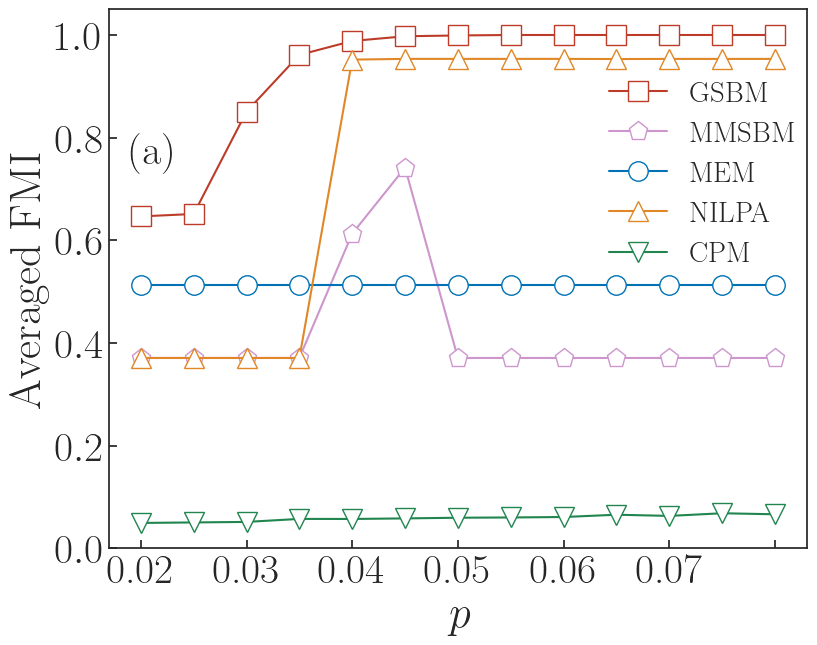

In [14]:
## 新指标FMI
fig = plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#CD96CD", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(SFMC_FMI_list_k, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(MMSBM_FMI_list_k, label="MMSBM", color=colorbar[1], alpha=alphabar, marker='p', markersize=14, markerfacecolor='white')
plt.plot(GA_FMI_list_k, label="MEM", color=colorbar[2], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(NILPA_FMI_list_k, label="NILPA", color=colorbar[3], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(CPM_FMI_list_k, label="CPM", color=colorbar[4], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(k_list)), k_list, rotation=90)

plt.legend(loc=(0.70, 0.5), fontsize='xx-large', frameon=False)
plt.text(-0.20, 0.75, '(a)', fontsize = 30)
plt.xticks(range(len(p_list)), p_list, rotation=0)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r"$p$", fontsize = 32)
plt.ylabel(r"Averaged FMI", fontsize = 32)

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数


fig_name = "AveragedFMI" + "_" + "k"
#save_file = "E:/学习/研三/Code/Overlapping/" + "1SparseNetwork" + "/" + fig_name + ".jpg"
save_file2 = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file2, dpi=300,bbox_inches = 'tight')
plt.show()

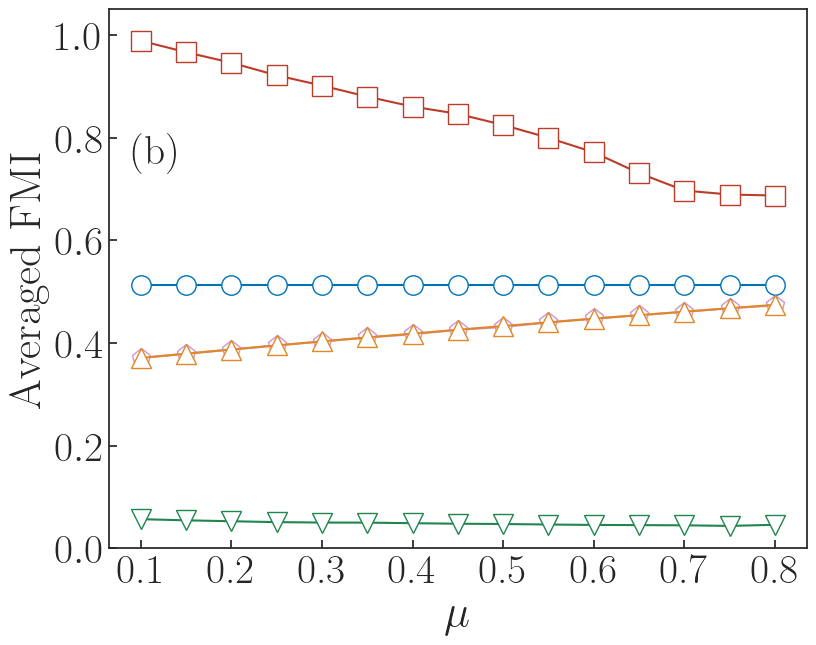

In [112]:
## 新指标FMI
plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#CD96CD", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(SFMC_FMI_list_overlap, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(MMSBM_FMI_list_overlap, label="MMSBM", color=colorbar[1], alpha=alphabar, marker='p', markersize=14, markerfacecolor='white')
plt.plot(GA_FMI_list_overlap, label="MEM", color=colorbar[2], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(NILPA_FMI_list_overlap, label="NILPA", color=colorbar[3], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(CPM_FMI_list_overlap, label="CPM", color=colorbar[4], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(overlap_list)), overlap_list, rotation=90)

#plt.scatter(p_list, RI_SFMC_k, s=30, color='r')
#plt.scatter(p_list, RI_LPA_k, s=30, color='r')
#plt.scatter(p_list, RI_CPM_k, s=30, color='r')
#plt.legend(loc=(0.62, 0.05), fontsize='xx-large')
plt.text(-0.20, 0.75, '(b)', fontsize = 30)

fig_name = "AveragedFMI" + "_" + "overlap"
plt.xticks(fontsize = 30, rotation=0)
plt.yticks(fontsize = 30)

plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

plt.xlabel(r"$\mu$", fontsize = 32)
plt.ylabel(r"Averaged FMI", fontsize = 32)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/Overlapping/" + "1SparseNetwork" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

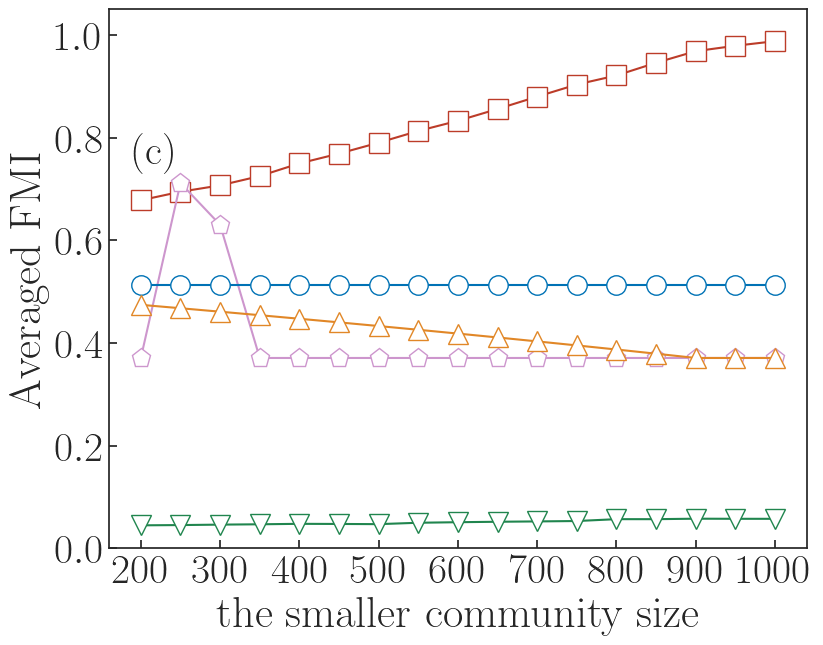

In [110]:
## 新指标ARC
plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#CD96CD", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(SFMC_FMI_list_unbalance, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(MMSBM_FMI_list_unbalance, label="MMSBM", color=colorbar[1], alpha=alphabar, marker='p', markersize=14, markerfacecolor='white')
plt.plot(GA_FMI_list_unbalance, label="MEM", color=colorbar[2], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(NILPA_FMI_list_unbalance, label="NILPA", color=colorbar[3], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(CPM_FMI_list_unbalance, label="CPM", color=colorbar[4], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(size_list)), np.array(size_list).astype(int), rotation=90)

#plt.scatter(p_list, RI_SFMC_k, s=30, color='r')
#plt.scatter(p_list, RI_LPA_k, s=30, color='r')
#plt.scatter(p_list, RI_CPM_k, s=30, color='r')
#plt.legend(loc=(0.62, 0.6), fontsize='xx-large')
plt.text(-0.20, 0.75, '(c)', fontsize = 30)
fig_name = "AveragedFMI" + "_" + "unbalance"
plt.xticks(fontsize = 30, rotation=0)
plt.yticks(fontsize = 30)

plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

plt.xlabel(r"the smaller community size", fontsize = 32)
plt.ylabel(r"Averaged FMI", fontsize = 32)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/Overlapping/" + "1SparseNetwork" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

## Rand Index 

In [35]:
## SingleFlip
pkl_number = 49
SFMC_logpost_list_k = []
SFMC_Ze_list_k = []
SFMC_RI_list_k = []
for i in p_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(overlap_size) + "p" + str(i) + "q" + str(q) + "/"
    datadir_SFMC_k = dir_SFMC + "/" + "k" + filedir + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir_SFMC_k + '.pkl','rb'))
    SFMC_logpost_list_k.append(data_temp[0])
    SFMC_Ze_list_k.append(data_temp[4])
    SFMC_RI_list_k.append(data_temp[5])
    
SFMC_logpost_list_overlap = []
SFMC_Ze_list_overlap = []
SFMC_RI_list_overlap = []
for i in overlap_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(i*n) + "p" + str(p) + "q" + str(q) + "/"
    datadir_SFMC_overlap = dir_SFMC + "/" + "overlap_size" + filedir + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir_SFMC_overlap + '.pkl','rb'))
    SFMC_logpost_list_overlap.append(data_temp[0])
    SFMC_Ze_list_overlap.append(data_temp[4])
    SFMC_RI_list_overlap.append(data_temp[5])
    
SFMC_logpost_list_unbalance = []
SFMC_Ze_list_unbalance = []
SFMC_RI_list_unbalance = []
for i in size_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(int(i)) + "op" + str(overlap_size) + "p" + str(p) + "q" + str(q) + "/"
    datadir_SFMC_unbalance = dir_SFMC + "/" + "unbalance" + filedir + "output_repeat" + str(pkl_number)
    data_temp = pickle.load(open(datadir_SFMC_unbalance + '.pkl','rb'))
    SFMC_logpost_list_unbalance.append(data_temp[0])
    SFMC_Ze_list_unbalance.append(data_temp[4])
    SFMC_RI_list_unbalance.append(data_temp[5])

In [36]:
RI_SFMC_k = [np.max(i) for i in SFMC_RI_list_k]
RI_SFMC_overlap = [np.max(i) for i in SFMC_RI_list_overlap]
RI_SFMC_unbalance = [np.max(i) for i in SFMC_RI_list_unbalance]

In [2]:
RI_SFMC_k = [0.7251315245264289,
 0.9221482339316734,
 0.9767594507403424,
 0.9950008271982794,
 0.9981838861775167,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]
RI_SFMC_k

[0.7251315245264289,
 0.9221482339316734,
 0.9767594507403424,
 0.9950008271982794,
 0.9981838861775167,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [3]:
RI_SFMC_overlap = [0.9777682190421044,
 0.9768664623301926,
 0.9724940922991382,
 0.9622097678142514,
 0.9578433114229881,
 0.9497070532355929,
 0.9355636679260696,
 0.9372937340853382,
 0.9180509228374472,
 0.8972410920677232,
 0.8821337554721701,
 0.8524203833360898,
 0.826206765225219,
 0.8279491954586294,
 0.8315321783706997]
RI_SFMC_overlap

[0.9777682190421044,
 0.9768664623301926,
 0.9724940922991382,
 0.9622097678142514,
 0.9578433114229881,
 0.9497070532355929,
 0.9355636679260696,
 0.9372937340853382,
 0.9180509228374472,
 0.8972410920677232,
 0.8821337554721701,
 0.8524203833360898,
 0.826206765225219,
 0.8279491954586294,
 0.8315321783706997]

In [4]:
RI_SFMC_unbalance = [0.9134844797019142,
 0.9316305884570675,
 0.9433465664884019,
 0.9468620205959835,
 0.9554051070194808,
 0.9562284953198417,
 0.9628455845699605,
 0.9700776883744897,
 0.9683242779525307,
 0.9760254311972806,
 0.9719691567507195,
 0.9839695124622191,
 0.9780848792206059,
 0.977360655000225,
 0.9794519679333303,
 0.976916917350185,
 0.9757122177185872]
RI_SFMC_unbalance

[0.9134844797019142,
 0.9316305884570675,
 0.9433465664884019,
 0.9468620205959835,
 0.9554051070194808,
 0.9562284953198417,
 0.9628455845699605,
 0.9700776883744897,
 0.9683242779525307,
 0.9760254311972806,
 0.9719691567507195,
 0.9839695124622191,
 0.9780848792206059,
 0.977360655000225,
 0.9794519679333303,
 0.976916917350185,
 0.9757122177185872]

In [5]:
RI_GA_k = [0.28577218959384565, 
            0.2821672594921003, 
            0.28018446521631235, 
            0.281158904789478, 
            0.2835966581189511, 
            0.282141616345438, 
            0.28795185706013726, 
            0.28152369923070564, 
            0.2849846968318306, 
            0.27972537017123, 
            0.2863446108032095]

In [6]:
RI_GA_overlap = [0.28428571428571425, 
0.3915230635335074, 
0.47758687795385046, 
0.5344499599679744, 
0.5840403860958133, 
0.6160426104384592, 
0.6366721127335853, 
0.651256276623593, 
0.6555823882588392, 
0.6558737166538245, 
0.6480847404627892, 
0.6375349615010015, 
0.6264335422220684, 
0.6108640039206077, 
0.5952785498116238]

In [7]:
RI_GA_unbalance = [0.7648102406923285, 
                   0.7142536680385811, 
                   0.6562505331539749,
                   0.6034493140374286, 
                   0.5477830407065778, 
                   0.4852321580524622, 
                   0.4272034970666053, 
                   0.37597447381981053, 
                   0.33178479513052006, 
                   0.2806085022451634, 
                   0.24744018213840802, 
                   0.20302948004730825, 
                   0.175776502513457, 
                   0.15099554635836065, 
                   0.14233887404320844, 
                   0.2180405566256195, 
                   0.28188601207709485]

In [41]:
## LabelPropagation
pkl_number = 1
res_save_list_k = []
for i in p_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(overlap_size) + "p" + str(i) + "q" + str(q) + "/"
    datadir_LPA_k = dir_LPA + "/" + "k" + filedir + "LPA_output" + str(pkl_number)
    data_temp = pickle.load(open(datadir_LPA_k + '.pkl','rb'))
    res_save_list_k.append(data_temp[0])
    
res_save_list_overlap = []
for i in overlap_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(i*n) + "p" + str(p) + "q" + str(q) + "/"
    datadir_LPA_overlap = dir_LPA + "/" + "overlap_size" + filedir + "LPA_output" + str(pkl_number)
    data_temp = pickle.load(open(datadir_LPA_overlap + '.pkl','rb'))
    res_save_list_overlap.append(data_temp[0])
    
res_save_list_unbalance = []
for i in size_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(int(i)) + "op" + str(overlap_size) + "p" + str(p) + "q" + str(q) + "/"
    datadir_LPA_unbalance = dir_LPA + "/" + "unbalance" + filedir + "LPA_output" + str(pkl_number)
    data_temp = pickle.load(open(datadir_LPA_unbalance + '.pkl','rb'))
    res_save_list_unbalance.append(data_temp[0])

In [42]:
def RI_index_LPA(label_list):
    if len(label_list) == 1:
        LPA_label = Zform(np.zeros((n)).astype(int), K).astype(int)
        RI = RIindex(LPA_label, Zc)
    else:
        label_temp = [np.array(i) for i in label_list]
        community_size = len(label_temp)
        Ze_LPAT = np.zeros((community_size, n)).astype(int)
        for i in range(community_size):
            for j in label_temp[i]:
                Ze_LPAT[i][j] += 1
        Ze_LPA = np.transpose(Ze_LPAT)
        RI = RIindex(Ze_LPA, Zc)
    return RI

In [8]:
RI_LPA_k = [0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237]
RI_LPA_k

[0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237,
 0.31350814790305237]

In [9]:
community_size_overlap = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
RI_LPA_overlap = [0.31350814790305237, 0.41926817270216066, 0.49972199054767863, 0.5598078462770216,
                  0.6034227512287558, 0.6336655410043104, 0.6530174614520576, 0.6634777849170652,
                  0.6666666666666667, 0.6639038713842438, 0.6562695434646655, 0.6446514875865998,
                  0.6297822248381401, 0.6122682349097444, 0.5926131801618183]
RI_LPA_overlap

[0.31350814790305237,
 0.41926817270216066,
 0.49972199054767863,
 0.5598078462770216,
 0.6034227512287558,
 0.6336655410043104,
 0.6530174614520576,
 0.6634777849170652,
 0.6666666666666667,
 0.6639038713842438,
 0.6562695434646655,
 0.6446514875865998,
 0.6297822248381401,
 0.6122682349097444,
 0.5926131801618183]

In [10]:
RI_LPA_unbalance = [0.7926920881036089,
 0.7376920418486286,
 0.6817808983234358,
 0.6254062745903042,
 0.5691085864881228,
 0.5135225128565615,
 0.4593734422332144,
 0.4074675968131912,
 0.358674782466604,
 0.31390322716018293,
 0.2740667554448215,
 0.24004555609093692,
 0.21264291116152856,
 0.19254127491115214,
 0.18026178721862407,
 0.2346893213781908, 
 0.3212819378547825]
RI_LPA_unbalance

[0.7926920881036089,
 0.7376920418486286,
 0.6817808983234358,
 0.6254062745903042,
 0.5691085864881228,
 0.5135225128565615,
 0.4593734422332144,
 0.4074675968131912,
 0.358674782466604,
 0.31390322716018293,
 0.2740667554448215,
 0.24004555609093692,
 0.21264291116152856,
 0.19254127491115214,
 0.18026178721862407,
 0.2346893213781908,
 0.3212819378547825]

In [ ]:
def RI_index_CPM(label_list):
    label_temp = [np.array(i) for i in label_list]
    community_size = len(label_temp)
    Ze_CPMT = np.zeros((community_size, n)).astype(int)
    for i in range(community_size):
        for j in label_temp[i]:
            Ze_CPMT[i][j] += 1
    Ze_CPM = np.transpose(Ze_CPMT)
    RI = RIindex(Ze_CPM, Zc)
    return RI

In [169]:
## CliquePercolation
CPM_save_list_k = []
for i in p_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(overlap_size) + "p" + str(i) + "q" + str(q) + "/"
    datadir_CPM_k = dir_CPM + "/" + "k" + filedir + "CPM_output"
    data_temp = pickle.load(open(datadir_CPM_k + '.pkl','rb'))
    CPM_save_list_k.append(data_temp)
    
CPM_save_list_overlap = []
for i in overlap_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(size[0]) + "op" + str(i*n) + "p" + str(p) + "q" + str(q) + "/"
    datadir_CPM_overlap = dir_CPM + "/" + "overlap_size" + filedir + "CPM_output"
    data_temp = pickle.load(open(datadir_CPM_overlap + '.pkl','rb'))
    CPM_save_list_overlap.append(data_temp)
    
CPM_save_list_unbalance = []
for i in size_list:
    filedir = "/K" + str(K) + "n" + str(n) + "size" + str(int(i)) + "op" + str(overlap_size) + "p" + str(p) + "q" + str(q) + "/"
    datadir_CPM_unbalance = dir_CPM + "/" + "unbalance" + filedir + "CPM_output"
    data_temp = pickle.load(open(datadir_CPM_unbalance + '.pkl','rb'))
    CPM_save_list_unbalance.append(data_temp)

In [13]:
community_num_k_3 = [1969, 1480, 824, 413, 190, 88, 22, 15, 2, 1, 1]
RI_CPM_k_3 = [0.01877905533956492, 0.2999851104309703, 0.31031350814790304, 0.3122880304408967,
              0.3130052113491604, 0.3132690876002978, 0.31345355281661014, 0.31347340557531644,
              0.3135056663082141, 0.31350814790305237, 0.31350814790305237]
assigned_num_k_3 = [1994, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
unassigned_num_k_3 = 2000 - np.array(assigned_num_k_3)
RI_CPM_k_3

[0.01877905533956492,
 0.2999851104309703,
 0.31031350814790304,
 0.3122880304408967,
 0.3130052113491604,
 0.3132690876002978,
 0.31345355281661014,
 0.31347340557531644,
 0.3135056663082141,
 0.31350814790305237,
 0.31350814790305237]

In [14]:
community_num_k_4 = [16, 38, 108, 214, 505, 985, 1583, 2393, 3637, 4675, 5697]
RI_CPM_k_4 = [5.4595086442232876e-05, 0.00016047646620898082, 0.0004913557779799849, 0.0009785755645628225,
              0.002416246174207992, 0.004919348167755855, 0.007759947059310157, 0.013039953676896365,
              0.023063115228720288, 0.03430143105302341, 0.11418148730250643]
assigned_num_k_4 = [63, 153, 390, 664, 1259, 1683, 1858, 1976, 1994, 2000, 2000]
unassigned_num_k_4 = 2000 - np.array(assigned_num_k_4)
unassigned_num_k_4

array([1937, 1847, 1610, 1336,  741,  317,  142,   24,    6,    0,    0])

In [15]:
community_num_overlap_3 = [879, 720, 619, 622, 497, 474, 399, 352, 348, 315, 286, 265, 232, 232, 216]
RI_CPM_overlap_3 = [0.3104309703035818, 0.4170825292314678, 0.4980824298026133, 0.5583583666933547, 0.6024954106709304,
                    0.6328896576339127, 0.6524343919125906, 0.6630613264796174, 0.6663446742272626, 0.6637031175159833,
                    0.6561260944340213, 0.6445702629692927, 0.6297572966797078, 0.6122822837539819, 0.592677104564264]
assigned_num_overlap_3 = [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
unassigned_num_overlap_3 = 2000 - np.array(assigned_num_overlap_3)
RI_CPM_overlap_3

[0.3104309703035818,
 0.4170825292314678,
 0.4980824298026133,
 0.5583583666933547,
 0.6024954106709304,
 0.6328896576339127,
 0.6524343919125906,
 0.6630613264796174,
 0.6663446742272626,
 0.6637031175159833,
 0.6561260944340213,
 0.6445702629692927,
 0.6297572966797078,
 0.6122822837539819,
 0.592677104564264]

In [16]:
community_num_overlap_4 = [100, 125, 130, 177, 209, 222, 228, 303, 316, 280, 331, 337, 367, 376, 427]
RI_CPM_overlap_4 = [0.0004475142691703349, 0.0005199228062209293, 0.0004719210453155709, 0.0006200160128102539, 0.0006881032747083626,
                    0.0006847321747247559, 0.0006856938629633547, 0.0008724209323909271, 0.0008281076273071175, 0.0007022220371103449,
                    0.0007747029393371241, 0.0007674072440597701, 0.0007644635252570531, 0.0007632116311361292, 0.0008313260453338689]
assigned_num_overlap_4 = [363, 432, 459, 599, 665, 698, 723, 886, 925, 847, 941, 962, 1003, 1034, 1112]
unassigned_num_overlap_4 = 2000 - np.array(assigned_num_overlap_4)
unassigned_num_overlap_4

array([1637, 1568, 1541, 1401, 1335, 1302, 1277, 1114, 1075, 1153, 1059,
       1038,  997,  966,  888])

In [17]:
community_num_unbalance_3 = [368, 405, 452, 531, 598, 620, 701, 797, 759, 876, 955, 953, 907, 957, 991, 988, 859]
RI_CPM_unbalance_3 = [0.7944379338321463, 0.7432888246567595, 0.6845421437711211, 0.6308693420917582, 0.5745396915844581,
                      0.5170209774686447, 0.4589363089075501, 0.407546077926196, 0.35777278483598185, 0.31238742708464473,
                      0.2713406933287512, 0.238381006614394, 0.20948173851149965, 0.18889378739484453, 0.17596720865981252,
                      0.24602419546821908, 0.3103201257341385]
assigned_num_unbalance_3 = [2000, 1999, 1999, 1997, 1999, 1999, 2000, 1998, 1998, 2000, 2000, 2000, 1999, 2000, 2000, 2000, 2000]
unassigned_num_unbalance_3 = 2000 - np.array(assigned_num_unbalance_3)
RI_CPM_unbalance_3

[0.7944379338321463,
 0.7432888246567595,
 0.6845421437711211,
 0.6308693420917582,
 0.5745396915844581,
 0.5170209774686447,
 0.4589363089075501,
 0.407546077926196,
 0.35777278483598185,
 0.31238742708464473,
 0.2713406933287512,
 0.238381006614394,
 0.20948173851149965,
 0.18889378739484453,
 0.17596720865981252,
 0.24602419546821908,
 0.3103201257341385]

In [18]:
community_num_unbalance_4 = [293, 260, 215, 219, 218, 175, 178, 146, 126, 126, 84, 95, 95, 88, 103, 112, 100]
RI_CPM_unbalance_4 = [0.0010475074371225634, 0.0009758396430927796, 0.0008661701499392827, 0.0009141605939306796, 0.0009053028954022491,
                      0.000789522364867401, 0.0007730357759117013, 0.0006595584446470459, 0.0005506760897096008, 0.0005606613789920223,
                      0.0003814596846943852, 0.0004678260107757737, 0.00042350638373589433, 0.00042197129875387596, 0.0004927759409393273,
                      0.0004821780249745222, 0.0004210439242285924]
assigned_num_unbalance_4 = [844, 789, 683, 681, 657, 560, 566, 492, 430, 431, 307, 337, 339, 320, 371, 395, 367]
unassigned_num_unbalance_4 = 2000 - np.array(assigned_num_unbalance_4)
RI_CPM_unbalance_4

[0.0010475074371225634,
 0.0009758396430927796,
 0.0008661701499392827,
 0.0009141605939306796,
 0.0009053028954022491,
 0.000789522364867401,
 0.0007730357759117013,
 0.0006595584446470459,
 0.0005506760897096008,
 0.0005606613789920223,
 0.0003814596846943852,
 0.0004678260107757737,
 0.00042350638373589433,
 0.00042197129875387596,
 0.0004927759409393273,
 0.0004821780249745222,
 0.0004210439242285924]

In [19]:
k_list = [round(i, 3) for i in np.linspace(20, 70, 11)]
p_list = [round(i, 3) for i in np.array(k_list) / 1000]
overlap_list = [round(i,4) for i in np.linspace(0.10, 0.80, 15)]
size_list = [round(i,4) for i in np.linspace(200, 1000, 17)]

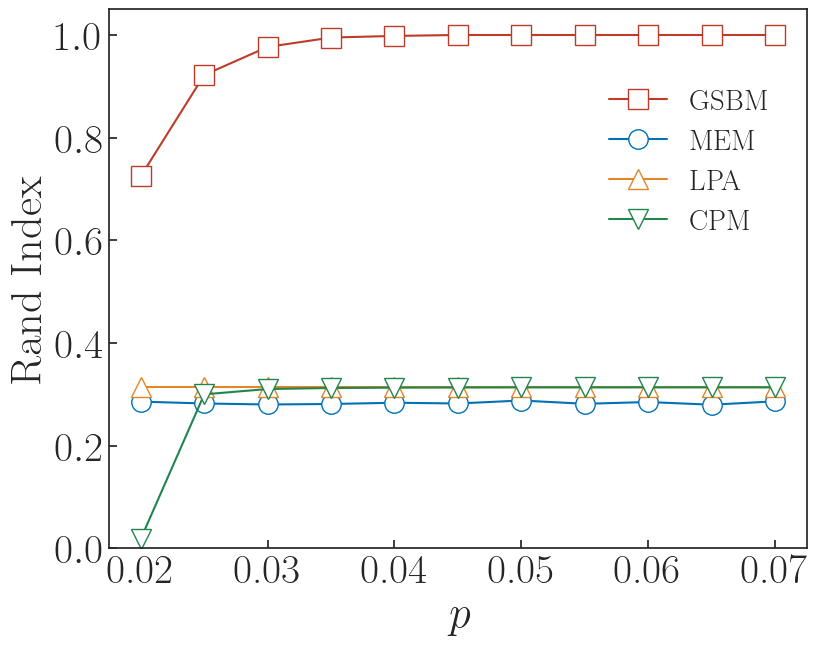

In [48]:
## p=0.40
fig = plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(RI_SFMC_k, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(RI_GA_k, label="MEM", color=colorbar[1], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(RI_LPA_k, label="LPA", color=colorbar[2], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(RI_CPM_k_3, label="CPM", color=colorbar[3], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(k_list)), k_list, rotation=90)

plt.legend(loc=(0.70, 0.56), fontsize='xx-large', frameon=False)
plt.text(9.4, 0.08, '(a)', fontsize = 30)
plt.xticks(range(len(p_list)), p_list, rotation=0)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r"$p$", fontsize = 32)
plt.ylabel(r"Rand Index", fontsize = 32)

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数


fig_name = "sparseRI" + "_" + "k"
# save_file = "E:/学习/研三/Code/Overlapping/" + "1SparseNetwork" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

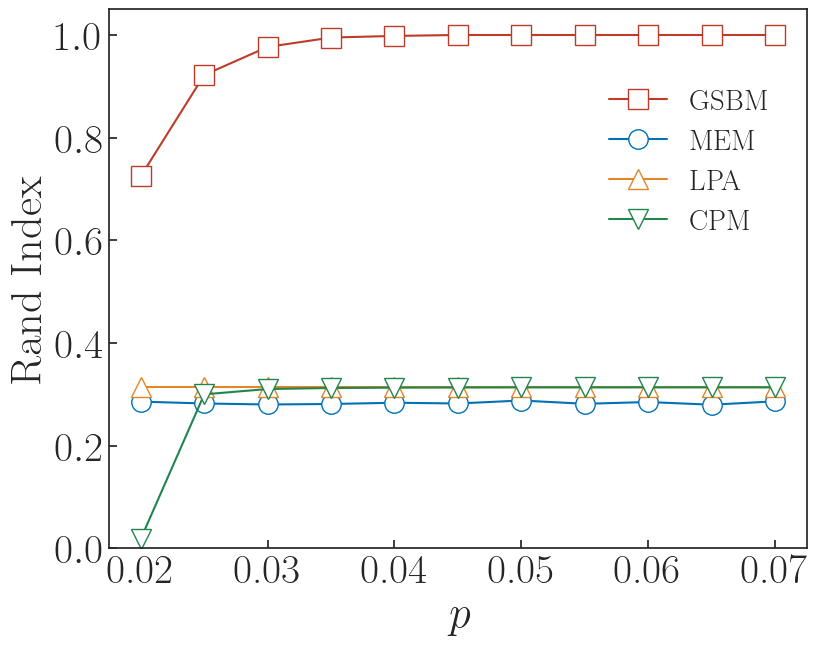

In [50]:
## 大论文用
## p=0.40
fig = plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(RI_SFMC_k, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(RI_GA_k, label="MEM", color=colorbar[1], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(RI_LPA_k, label="LPA", color=colorbar[2], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(RI_CPM_k_3, label="CPM", color=colorbar[3], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(k_list)), k_list, rotation=90)

plt.legend(loc=(0.70, 0.56), fontsize='xx-large', frameon=False)
#plt.text(9.4, 0.08, '(a)', fontsize = 30)
plt.xticks(range(len(p_list)), p_list, rotation=0)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel(r"$p$", fontsize = 32)
plt.ylabel(r"Rand Index", fontsize = 32)

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数


fig_name = "sparseRI" + "_" + "k"
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

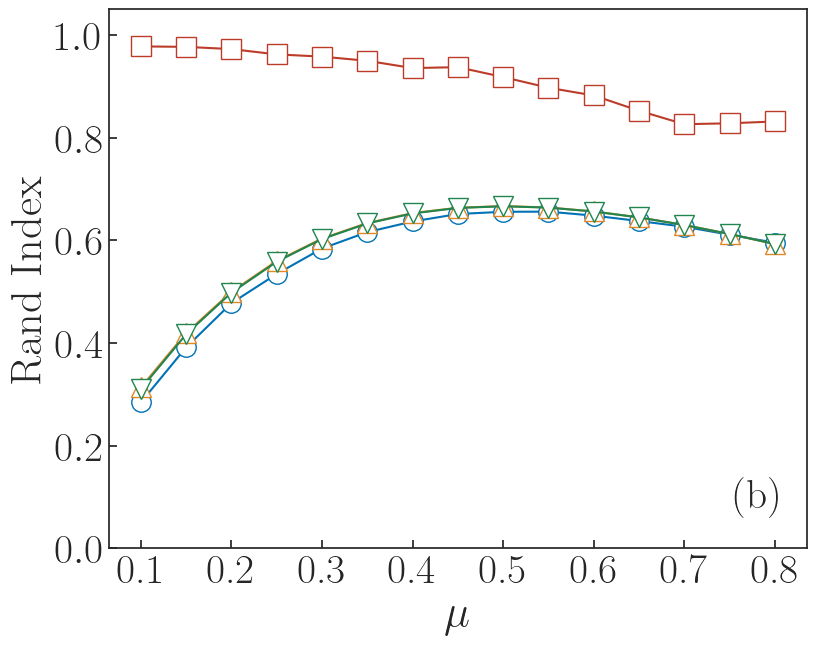

In [70]:
## p=0.40
plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(RI_SFMC_overlap, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(RI_GA_overlap, label="MEM", color=colorbar[1], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(RI_LPA_overlap, label="LPA", color=colorbar[2], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(RI_CPM_overlap_3, label="CPM", color=colorbar[3], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(overlap_list)), overlap_list, rotation=90)

#plt.scatter(p_list, RI_SFMC_k, s=30, color='r')
#plt.scatter(p_list, RI_LPA_k, s=30, color='r')
#plt.scatter(p_list, RI_CPM_k, s=30, color='r')
#plt.legend(loc=(0.62, 0.05), fontsize='xx-large')
plt.text(13.1, 0.08, '(b)', fontsize = 30)

fig_name = "sparseRI" + "_" + "overlap"
plt.xticks(fontsize = 30, rotation=0)
plt.yticks(fontsize = 30)

plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

plt.xlabel(r"$\mu$", fontsize = 32)
plt.ylabel(r"Rand Index", fontsize = 32)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/Overlapping/" + "1SparseNetwork" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

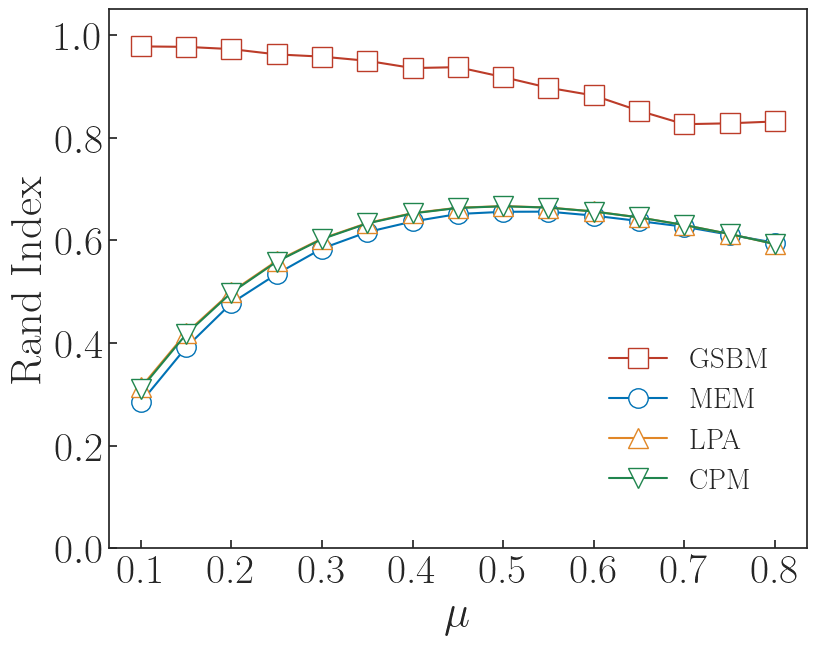

In [57]:
## 大论文用
## p=0.40
plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(RI_SFMC_overlap, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(RI_GA_overlap, label="MEM", color=colorbar[1], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(RI_LPA_overlap, label="LPA", color=colorbar[2], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(RI_CPM_overlap_3, label="CPM", color=colorbar[3], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(overlap_list)), overlap_list, rotation=90)

#plt.scatter(p_list, RI_SFMC_k, s=30, color='r')
#plt.scatter(p_list, RI_LPA_k, s=30, color='r')
#plt.scatter(p_list, RI_CPM_k, s=30, color='r')
#plt.legend(loc=(0.62, 0.05), fontsize='xx-large')
#plt.text(13.1, 0.08, '(b)', fontsize = 30)

plt.legend(loc=(0.70, 0.08), fontsize='xx-large', frameon=False)
fig_name = "sparseRI" + "_" + "overlap"
plt.xticks(fontsize = 30, rotation=0)
plt.yticks(fontsize = 30)

plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

plt.xlabel(r"$\mu$", fontsize = 32)
plt.ylabel(r"Rand Index", fontsize = 32)
#plt.title(fig_name)
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

In [259]:
np.array(size_list).astype(int)

array([ 200,  250,  300,  350,  400,  450,  500,  550,  600,  650,  700,
        750,  800,  850,  900,  950, 1000])

In [74]:
len(RI_LPA_unbalance)

15

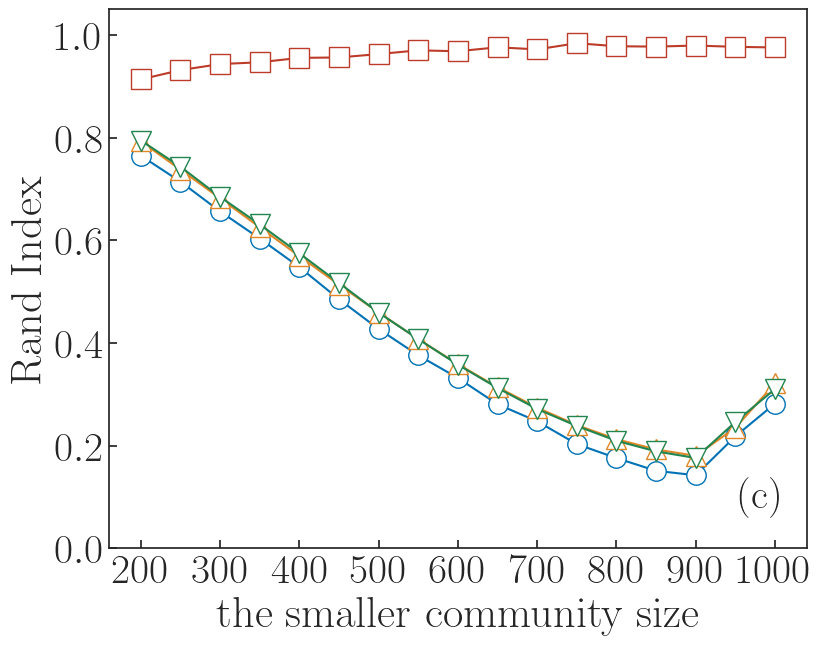

In [69]:
## p=0.40
plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(RI_SFMC_unbalance, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(RI_GA_unbalance, label="MEM", color=colorbar[1], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(RI_LPA_unbalance, label="LPA", color=colorbar[2], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(RI_CPM_unbalance_3, label="CPM", color=colorbar[3], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(size_list)), np.array(size_list).astype(int), rotation=90)

#plt.scatter(p_list, RI_SFMC_k, s=30, color='r')
#plt.scatter(p_list, RI_LPA_k, s=30, color='r')
#plt.scatter(p_list, RI_CPM_k, s=30, color='r')
#plt.legend(loc=(0.62, 0.6), fontsize='xx-large')
plt.text(15.1, 0.08, '(c)', fontsize = 30)
fig_name = "sparseRI" + "_" + "unbalance"
plt.xticks(fontsize = 30, rotation=0)
plt.yticks(fontsize = 30)

plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

plt.xlabel(r"the smaller community size", fontsize = 32)
plt.ylabel(r"Rand Index", fontsize = 32)
#plt.title(fig_name)
save_file = "E:/学习/研三/Code/Overlapping/" + "1SparseNetwork" + "/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()

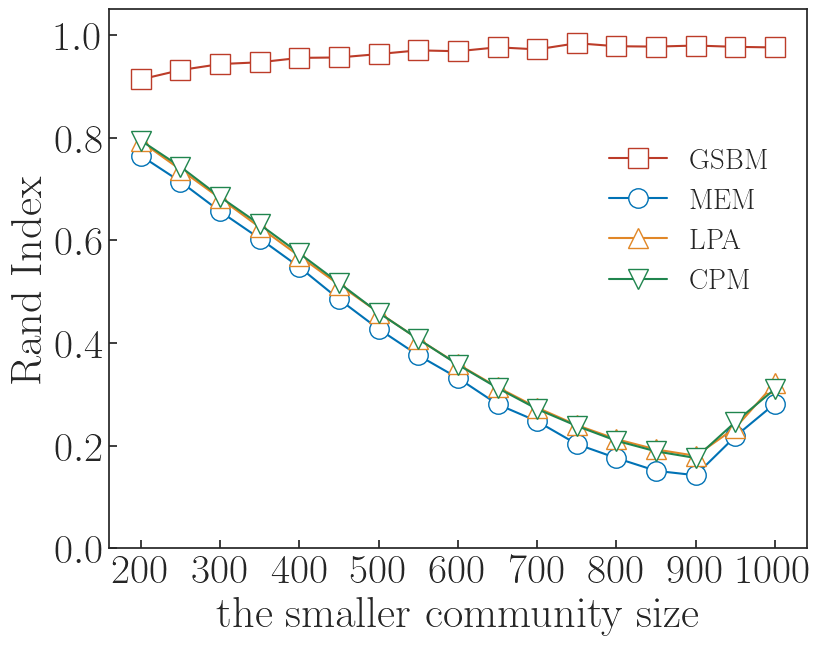

In [61]:
## 大论文用
## p=0.40
plt.figure(figsize=(9,7))
colorbar = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF"]
alphabar = 1

plt.plot(RI_SFMC_unbalance, label="GSBM", color=colorbar[0], alpha=alphabar, marker='s', markersize=14, markerfacecolor='white')
plt.plot(RI_GA_unbalance, label="MEM", color=colorbar[1], alpha=alphabar, marker='o', markersize=14, markerfacecolor='white')
plt.plot(RI_LPA_unbalance, label="LPA", color=colorbar[2], alpha=alphabar, marker='^', markersize=14, markerfacecolor='white')
plt.plot(RI_CPM_unbalance_3, label="CPM", color=colorbar[3], alpha=alphabar, marker='v', markersize=14, markerfacecolor='white')
plt.xticks(range(len(size_list)), np.array(size_list).astype(int), rotation=90)

#plt.scatter(p_list, RI_SFMC_k, s=30, color='r')
#plt.scatter(p_list, RI_LPA_k, s=30, color='r')
#plt.scatter(p_list, RI_CPM_k, s=30, color='r')

#plt.text(15.1, 0.08, '(c)', fontsize = 30)
plt.legend(loc=(0.70, 0.45), fontsize='xx-large', frameon=False)
fig_name = "sparseRI" + "_" + "unbalance"
plt.xticks(fontsize = 30, rotation=0)
plt.yticks(fontsize = 30)

plt.tick_params(axis='x')
plt.tick_params(axis='y')

plt.ylim(0,1.05)
x_major_locator=MultipleLocator(2)       # 把x轴的刻度间隔设置为1，并存在变量里
y_major_locator=MultipleLocator(0.2)    # 把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()               # ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)     # 把x轴的主刻度设置为1的倍数
ax.yaxis.set_major_locator(y_major_locator)     # 把y轴的主刻度设置为1的倍数

plt.xlabel(r"the smaller community size", fontsize = 32)
plt.ylabel(r"Rand Index", fontsize = 32)
#plt.title(fig_name)
save_file = "E:/学习/研三/大论文/Figure/" + fig_name + ".jpg"
plt.savefig(save_file, dpi=300,bbox_inches = 'tight')
plt.show()